## Preliminaries

In [1]:
import math
from typing import NamedTuple, List, Tuple, Dict, Any

import pysam
import numpy as np
rng = np.random.default_rng()
import scipy.stats

from numpy.typing import NDArray
import pandas as pd
# from utils import genomeSampling
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
matplotlib.rcParams["svg.fonttype"] = 'none'

# import array
import gzip
import io
import sys
from argparse import ArgumentParser
import re
import random
import json

import pdb

In [2]:
COLS = ['#1B98E0', '#df5353', '#ff9c33', '#f9d839', '#32a896']
COLS_AREA = ['#49afe9', '#e36969', 'ffa84d']
COL_gray = '#666666'
CONTEXTS = ['CG', 'CHG', 'CHH']
STRANDS = ['double', 'W', 'C']

In [3]:
def axlimit(x):
    k = int(np.log10(x))
    if x < 1: k -= 1
    return (int(x * 10**(1-k))+1) * 10**(k-1)

def prefixBpSize(x):
    if max(x) >= 1e9: 
        x = x/1e9
        prefix = 'Gbp'
    elif max(x) >= 1e6:
        x = x/1e6
        prefix = 'Mbp'
    elif max(x) >= 1e3:
        x = x/1e3
        prefix = 'Kbp'
    else: prefix = ''
    return x, prefix

# divide keeping nan's
def nandivide(x, y):
    i = (y != 0)
    q = np.zeros(np.shape(x), dtype=float)
    q[i] = x[i]/y[i]
    q[~i] = math.nan
    return q

# trim values larger than quantile 0.99
def trimQuantile(x, q=0.99):
    return np.fmin(x, np.quantile(x, q))

def depthDiff(x: NDArray):
    return -np.diff(np.hstack([x, 0]))
def depthCulSum(x: NDArray):
    return np.cumsum(x[::-1])[::-1]

def signif(x, digit=3):
    return np.floor(np.array(x)*10**digit)/10**digit


In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [5]:
def reverseComp(str: str) -> str:
    comp = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join([comp[s] for s in str[::-1]])

# 3-nucleotide context, CG/CHG/CHH etc.

CG_CONTEXT_FORWARD_HASH = {'CGA':'CG', 'CGT':'CG', 'CGC':'CG', 'CGG':'CG', 'CGN':'CG', # 4 CG
                           'CAG':'CHG', 'CTG':'CHG', 'CCG':'CHG',          # 3 CHG
                           'CAA':'CHH', 'CAT':'CHH', 'CAC':'CHH',          # 9 CHH
                           'CTA':'CHH', 'CTT':'CHH', 'CTC':'CHH',
                           'CCA':'CHH', 'CCT':'CHH', 'CCC':'CHH'
                           }

CG_CONTEXT_REVERSE_HASH = {'ACG':'CG', 'TCG':'CG', 'CCG':'CG', 'GCG':'CG', 'NCG':'CG', # 4 CG
                           'CAG':'CHG', 'CTG':'CHG', 'CGG':'CHG',          # 3 CHG
                           'AAG':'CHH', 'ATG':'CHH', 'AGG':'CHH',          # 9 CHH
                           'TAG':'CHH', 'TTG':'CHH', 'TGG':'CHH',
                           'GAG':'CHH', 'GTG':'CHH', 'GGG':'CHH'
                           }

# 2-nucleotide context of reverse strand

DI_CONTEXT_REVERSE_HASH = {'AG':'CT', 'TG':'CA', 'CG':'CG', 'GG':'CC'}

def as_bool(x: str):
    x = x.upper()
    if x in ["TRUE", "T", "YES", "Y"] : return True
    if x in ["FALSE", "F", "NO", "N"] : return False
    return None


In [6]:
class Parameters(NamedTuple):
    fafile: str
    bamfile: str
    out_atcg: str
    out_cg: str
    out_bed: str
    chr: str
    start: int
    end: int
    step: int
    quality_threshold: int
    context_size: int
    cgkmer: int
    coordinate_base: int  # 0/1-based
    swap_strand: bool # swap the counts of forward and reverse strands
    read_quality: int


In [7]:
## fa methods
# interval must be involved in single chr
class GenomicInterval(NamedTuple):
    chr: str
    chr_length: int
    start: int
    end: int



# `ref` includes ref bases from `start`-2 to `end`-2
class FaGenomicInterval(NamedTuple):
    chr: str
    start: int
    end: int
    bases: str

class MyFastaFile(pysam.FastaFile):

    def rich_fetch(self, intrv: GenomicInterval, padding:int) -> str:

        bases = self.fetch(reference=intrv.chr, 
                           start=max(0, intrv.start-padding), 
                           end=min(intrv.chr_length, intrv.end+padding)
                           ).upper()
        
        # padding N
        if intrv.start < padding:
            bases = "N"*(padding-intrv.start) + bases
        if intrv.end+padding > intrv.chr_length:
            bases = bases + "N"*(intrv.end+padding-intrv.chr_length)

        return bases


In [8]:
fafile = 'genome/hg38.fa'
bamfile = 'data/ENCFF873NOV.bam'

fa = MyFastaFile(fafile)

binSize = 100_000 # bin length
bins_lambda = 1000 # #bins
bins_MT = 1000

# max depth for counting
MAXDEPTH = 1000

def getBins(length, bins):
    size = math.ceil(length/bins)
    if size > 10: size = math.ceil(size/10)*10
    bins = math.ceil(length/size)
    return (size, bins)

binSize_lambda = getBins(fa.get_reference_length('chrL'), bins_lambda)
binSize_MT = getBins(fa.get_reference_length('chrM'), bins_lambda)

binSizeContig = {'lambda': binSize_lambda[0], 'MT': binSize_MT[0]}
binsContig = {'lambda': binSize_lambda[1], 'MT': binSize_MT[1]}

chrs_alias = {'chrL': 'lambda', 'chrM': 'MT'}

# gene pading for pan-gene summary
gene_padding = 5_000 # up-/down-stream
gene_breaks = 50 # breaks of up body down

# read sampling
reads_to_sample = 100_000
reads_sample_window = 10 # bp
max_reads_per_batch = 500


In [9]:
class GenomicIntervalGenerator:
    
    def __init__(self, 
                 fa: pysam.FastaFile, 
                 chrs,
                 start: int,
                 end: int,
                 step: int,
                 spacing: int = 0
                 ) -> None:
        
        self.chrs = fa.references
        self.lens = fa.lengths
        if chrs == "all":
            self.chrs_selected = list(self.chrs)
        else:
            self.chrs_selected = chrs.split(',')
        
        self.start = start
        self.end = end
        self.step = step
        self.spacing = spacing

        assert(step > 0 and start < end)
        assert(len(self.chrs) > 0 and len(self.chrs) == len(self.lens))
        assert(isinstance(spacing, int) and spacing >= 0)
    
    def __iter__(self):
        for (chr, len) in zip(self.chrs, self.lens):
            if chr not in self.chrs_selected:
                continue

            end2 = min(self.end, len)
            start = self.start + rng.integers(low=0, high=self.spacing*2+1, size=1)[0]
            end = start + self.step
            while start < end2:
                # if start < end2:
                end = min(end, end2)
                yield GenomicInterval(chr=chr, chr_length=len, start=start, end=end)
                start = end + rng.integers(low=0, high=self.spacing*2+1, size=1)[0]
                end = start + self.step
                # else:
                #     break


In [10]:
## gene intervals
class Gene():
    def __init__(self, chr, chr_length, start, end, strand, biotype=None) -> None:
        self.chr: str = chr
        self.chr_length: int = chr_length
        self.start: int = start
        self.end: int = end
        self.strand: str = strand
        self.biotype: str | None = biotype
        
        self.start_padding = max(0, start-gene_padding)
        self.end_padding = min(chr_length, end+gene_padding)
        breaks1 = np.linspace(self.start_padding-1, start, num=gene_breaks+1)
        breaks2 = np.linspace(start, end, num=gene_breaks+1)
        breaks3 = np.linspace(end, self.end_padding+1, num=gene_breaks+1)
        self.breaks = np.block([breaks1, breaks2[1:], breaks3[1:]])
        # bins = np.zeros(gene_breaks*3, dtype=int)
        if strand == '+':
            bins = np.arange(0, gene_breaks*3, dtype=int)
        else:
            bins = -np.arange(-(gene_breaks*3-1), 1)
        self.bins = bins

def genesGenerator(file: str):
    gtf = gzip.open(file, 'rt')
    while line := gtf.readline().strip():
        if line.startswith('#'): continue
        keys = line.split('\t')
        if keys[2] != 'gene': continue
        m = re.search(r'gene_type=([^;]*);', keys[8])
        if m is None: biotype = None
        else: biotype = m.group(1)
        chr_length = fa.get_reference_length(keys[0])
        yield Gene(chr=keys[0], chr_length=chr_length, start=int(keys[3]), end=int(keys[4]), strand=keys[6], biotype=biotype)
    gtf.close()


In [11]:
## coverage of pangene
class CovPanGene():
    def __init__(self, bins=gene_breaks*3) -> None:
        self.nCG = np.zeros((bins,), dtype=np.int64)
        self.meCG = np.zeros((bins,), dtype=np.float64)
        self.nCGW = np.zeros((bins,), dtype=np.int64)
        self.meCGW = np.zeros((bins,), dtype=np.float64)
        self.nCGC = np.zeros((bins,), dtype=np.int64)
        self.meCGC = np.zeros((bins,), dtype=np.float64)
        
# cov_pangene = CovPanGene()

In [12]:
class Quality():
    def __init__(self) -> None:
        self.base_quality = list() # quality itself
        self.read_length = list()
        self.nreads: int = 0
        self.ndup: int = 0
        self.nqcfail: int = 0
        self.npaired: int = 0
        self.nproperpaired: int = 0
        # self.nbases: int = 0
        self.ncigars: NDArray = np.zeros((10,), dtype=np.int64)
        self.map_quality = list() # quality itself
    
    def regulalization(self):
        self.base_quality = np.hstack(self.base_quality, dtype=np.uint8)
        self.map_quality = np.hstack(self.map_quality, dtype=int)
        self.read_length = np.array(self.read_length, dtype=int)


In [13]:
## bam methods

class Coverage(NamedTuple):
    watson: NDArray[np.int32]
    crick: NDArray[np.int32]

def check_read(forward_read: bool, read_quality: int):
    def valid_read(read: pysam.AlignedSegment):
        return (forward_read ^ read.is_reverse) and (not read.is_unmapped) and (not read.is_duplicate) and (not read.is_secondary) and (not read.is_qcfail) and (read.mapping_quality>=read_quality)
    return valid_read

class IntervalCoverage(NamedTuple):
    chr: str
    length: int
    start: int
    end: int
    bin: NDArray[np.int32]
    base: str
    cgContext: List[str]
    cgkmer: List[str]
    covW: NDArray[np.int32]
    covC: NDArray[np.int32]
    covWsum: NDArray[np.int32]
    covCsum: NDArray[np.int32]
    covMeth: NDArray[np.int32]
    meth: NDArray[np.float32]

    def printInterval(self):
        for i in range(self.length):
            print(f'{self.chr}\t{self.start+i}\t{self.bin[i]}\t{self.base[i]}\t{self.cgContext[i]}\t{self.cgkmer[i]}\t{self.covWsum[i]}\t{self.covCsum[i]}\t{self.covMeth[i]}\t{self.meth[i]:.2f}')

class MyAlignmentFile(pysam.AlignmentFile):

    def Watson_Crick_coverage(self, intrv: GenomicInterval, 
                              params: Parameters
                              ) -> Coverage:

        # 4 X nbases
        cov_watson = self.count_coverage(contig=intrv.chr, 
                                         start=intrv.start, 
                                         stop=intrv.end, 
                                         quality_threshold=params.quality_threshold,
                                         read_callback=check_read(forward_read=True, read_quality=params.read_quality)
                                         )
        cov_crick = self.count_coverage(contig=intrv.chr, 
                                         start=intrv.start, 
                                         stop=intrv.end, 
                                         quality_threshold=params.quality_threshold,
                                         read_callback=check_read(forward_read=False, read_quality=params.read_quality)
                                         )
        
        # in some bams, the read strandness seem be reversly flaged in `FLAG`
        # parsed in read.is_reverse
        # for example gemBS

        if params.swap_strand:
            cov_watson, cov_crick = cov_crick, cov_watson
        return Coverage(watson=np.array(cov_watson, dtype=np.int32), 
                        crick=np.array(cov_crick, dtype=np.int32)
                        )
    
    def detailedCoverage(self, interval: GenomicInterval, params: Parameters) -> IntervalCoverage:
        # context size
        consize = params.context_size
        # ref sequences
        bases = fa.rich_fetch(interval, padding=params.cgkmer//2).upper()

        # bam coverages
        covs = self.Watson_Crick_coverage(interval, params)
        cov_sum_W = np.sum(covs.watson, axis=0, dtype=np.int32)
        cov_sum_C = np.sum(covs.crick, axis=0, dtype=np.int32)

        CG_contexts = []
        cgkmers = []
        length = interval.end - interval.start
        covMeths = np.array([0]*length, dtype=np.int32)
        meth = np.array([math.nan]*length, dtype=np.float32)
        bin = np.array([0]*length, dtype=np.int32)

        # bin index
        kbin = interval.start // binSize
        nbases = 0 # bases taken
        # keep = np.array([False]*length, dtype=np.bool_) # which bases to take
        
        for i in range(length):
            # skip A/Ts
            j = i+params.cgkmer//2
            base = bases[j]
            # if base == 'A' or base == 'T' or base == 'N': continue

            # bin index
            if i + interval.start >= (kbin + 1) * binSize:
                kbin += 1
            bin[i] = kbin

            CG_context = "-"
            meth_ratio = math.nan
            cgkmer = '-'
            nCT = 0
            
            if base == 'C' or base == 'G':
                if base == 'C':
                    # CG/CHG/CHH
                    bases_con = bases[j:(j+consize)]
                    CG_context = '-' if 'N' in bases_con else CG_CONTEXT_FORWARD_HASH[bases_con]
                    
                    # dinucleatide context CA/CT/...
                    # dicontext = bases[j:(j+2)]
                    nCT = covs.watson[1,i] + covs.watson[3,i]
                    nC = covs.watson[1,i]
                    # CG kmer
                    if CG_context == 'CG':
                        cgkmer = bases[(j-2):(j+4)]
                        if 'N' in cgkmer: 
                            cgkmer = '-'
                else:
                    bases_con = bases[(j-consize+1):(j+1)]
                    CG_context = '-' if 'N' in bases_con else CG_CONTEXT_REVERSE_HASH[bases_con]
                    nC = covs.crick[2,i]
                    nCT = covs.crick[0,i] + covs.crick[2,i]
                    if CG_context == 'CG':
                        kmer = bases[(j-3):(j+3)]
                        if 'N' in kmer: 
                            cgkmer = '-'
                        else:
                            cgkmer = reverseComp(kmer)
                        
                meth_ratio = nC/nCT if nCT>0 else math.nan
            cgkmers.append(cgkmer)
            CG_contexts.append(CG_context)
            meth[i] = meth_ratio
            covMeths[i] = nCT

        return IntervalCoverage(
            chr=interval.chr, 
            length=length,
            start=interval.start, 
            end=interval.end, 
            bin = bin,
            base=bases[(params.cgkmer//2):(length+params.cgkmer//2)],
            cgContext=CG_contexts, 
            cgkmer=cgkmers, 
            covW=covs.watson,
            covC=covs.crick,
            covWsum=cov_sum_W, 
            covCsum=cov_sum_C, 
            covMeth=covMeths,
            meth=meth
            )
    
    # for extral contigs: MT, lambda DNA
    def detailedCoverageContig(self, interval: GenomicInterval, params: Parameters) -> IntervalCoverage:
        # ref sequences
        bases = fa.rich_fetch(interval, padding=params.cgkmer//2).upper()

        # bam coverages
        covs = self.Watson_Crick_coverage(interval, params)
        cov_sum_W = np.sum(covs.watson, axis=0, dtype=np.int32)
        cov_sum_C = np.sum(covs.crick, axis=0, dtype=np.int32)

        length = interval.end - interval.start
        covMeths = np.zeros((length,), dtype=np.int32)
        meth = np.array([math.nan]*length, dtype=np.float32)
        bin = np.zeros((length,), dtype=np.int32)

        # bin index 
        binSize = binSizeContig[chrs_alias[interval.chr]]
        kbin = interval.start // binSize
        
        for i in range(length):
            j = i+params.cgkmer//2
            base = bases[j]
            # if base == 'N': continue # processed in next step

            # bin index
            if i + interval.start >= (kbin + 1) * binSize:
                kbin += 1
            bin[i] = kbin

            meth_ratio = math.nan
            nCT = 0
            
            if base == 'C' or base == 'G':
                if base == 'C':
                    # dinucleatide context CA/CT/...
                    # dicontext = bases[j:(j+2)]
                    nCT = covs.watson[1,i] + covs.watson[3,i]
                    nC = covs.watson[1,i]
                else:
                    nC = covs.crick[2,i]
                    nCT = covs.crick[0,i] + covs.crick[2,i]
                meth_ratio = nC/nCT if nCT>0 else math.nan

            meth[i] = meth_ratio
            covMeths[i] = nCT

        return IntervalCoverage(
            chr=interval.chr, 
            length=length,
            start=interval.start, 
            end=interval.end, 
            bin = bin,
            base=bases[(params.cgkmer//2):(length+params.cgkmer//2)],
            cgContext=[''], 
            cgkmer=[''], 
            covW=covs.watson,
            covC=covs.crick,
            covWsum=cov_sum_W, 
            covCsum=cov_sum_C, 
            covMeth=covMeths,
            meth=meth
            )

    def update_pangene(self, cov_pangene: CovPanGene, g: Gene, params: Parameters):
        # context size
        consize = params.context_size

        intv = GenomicInterval(chr=g.chr, chr_length=g.chr_length, start=g.start_padding, end=g.end_padding)
        
        # ref sequences
        bases = fa.rich_fetch(intv, padding=params.cgkmer//2).upper()

        # bam coverages
        covs = self.Watson_Crick_coverage(intv, params)
        
        for i in range(g.end_padding - g.start_padding):
            j = i+params.cgkmer//2

            base = bases[j]
            if base == 'C' or base == 'G':
                if base == 'C':
                    # CG/CHG/CHH
                    bases_con = bases[j:(j+consize)]
                    CG_context = '-' if 'N' in bases_con else CG_CONTEXT_FORWARD_HASH[bases_con]
                    if CG_context != 'CG': continue
                    nCT = covs.watson[1,i] + covs.watson[3,i]
                    nC = covs.watson[1,i]
                else:
                    bases_con = bases[(j-consize+1):(j+1)]
                    CG_context = '-' if 'N' in bases_con else CG_CONTEXT_REVERSE_HASH[bases_con]
                    if CG_context != 'CG': continue
                    nC = covs.crick[2,i]
                    nCT = covs.crick[0,i] + covs.crick[2,i]

                # pdb.set_trace()
                if nCT <= 0: continue
                meth_ratio = nC/nCT
                kbin = g.bins[np.argmax(g.start_padding + i < g.breaks) - 1]
                cov_pangene.nCG[kbin] += 1
                cov_pangene.meCG[kbin] += meth_ratio
                if base == 'C':
                    cov_pangene.nCGW[kbin] += 1
                    cov_pangene.meCGW[kbin] += meth_ratio
                else:
                    cov_pangene.nCGC[kbin] += 1
                    cov_pangene.meCGC[kbin] += meth_ratio

    # for reads and bases sampling
    def sample_reads(self, quality: Quality, gi: GenomicInterval, params: Parameters):
        reads = self.fetch(contig=gi.chr, start=gi.start, stop=gi.end)
        k = 0
        for r in reads:
            if k > max_reads_per_batch: return
            k += 1
            quality.nreads += 1
            quality.nqcfail += r.is_qcfail
            quality.npaired += r.is_paired
            quality.nproperpaired += r.is_proper_pair
            quality.ndup += r.is_duplicate

            quality.read_length.append(r.query_length)
            quality.base_quality.append(r.query_qualities)
            quality.map_quality.append(r.mapping_quality)

            # cigar
            cigar = r.cigartuples
            if cigar is not None:
                for c in cigar:
                    if c[0] < 10:
                        quality.ncigars[c[0]] += c[1]


def myOpenFile(file: str):
    if file == '':
        return None
    if file == '-':
        outfile = sys.stdout
    elif file.endswith('.gz'):
        outfile = gzip.open(file, 'wt')
    else:
        outfile = io.open(file, 'wt')
    return outfile


In [14]:
## random genomic region
def randomGenomicRegion(fa: pysam.FastaFile, bam: pysam.AlignmentFile, size=100):
    chrs = fa.references
    lens = fa.lengths
    reads = np.zeros((len(chrs),), dtype=int)
    mappedreads = {}
    for c in bam.get_index_statistics():
        mappedreads[c.contig] = c.mapped
    for i, c in enumerate(chrs):
        value = mappedreads.get(c)
        if value is None: reads[i] = 0
        else: reads[i] = value
    # prop
    p = reads/np.sum(reads)
    idx = list(range(len(chrs)))
    while(True):
        ci = random.choices(idx, weights=p, k=1)[0]
        if lens[ci] <= size:
            a, b = 0, lens[ci]
        else:
            pos = random.randrange(0, lens[ci])
            a, b = max(0, pos-int(size/2)), min(lens[ci], pos+int(size/2))
        yield GenomicInterval(chr=chrs[ci], chr_length=lens[ci], start=a, end=b)
    

In [15]:
bam = MyAlignmentFile(bamfile, 'rb')

In [16]:
# classes
# ('chr1', 23) -> BinCov()
dict_binning = dict()

# 'XXCGXX' -> KmerCov()
dict_cgkmer = dict()

# 

class KmerCov():
    def __init__(self):
        self.n: int = 0
        self.nW: int = 0
        self.nC: int = 0
        self.dp: int = 0
        self.dpW: int = 0
        self.dpC: int = 0

        init = np.array([0]*MAXDEPTH, dtype=np.int64)
        init2 = np.array([0]*MAXDEPTH, dtype=np.float64)
        self.cov: NDArray[np.int64] = init.copy()
        self.covW: NDArray[np.int64] = init.copy()
        self.covC: NDArray[np.int64] = init.copy()
        self.me: NDArray[np.float64] = init2.copy()
        self.meW: NDArray[np.float64] = init2.copy()
        self.meC: NDArray[np.float64] = init2.copy()
    
class BinCov():
    def __init__(self) -> None:     
        init = np.array([0]*MAXDEPTH, dtype=np.int64)
        init2 = np.array([0]*MAXDEPTH, dtype=np.float64)
 
        self.length: int = 0 # bases sampled
        self.nCG: int = 0 # CGs/CHGs/CHHs in the genome
        self.nCGW: int = 0
        self.nCGC: int = 0
        self.nCHG: int = 0 # CGs/CHGs/CHHs in the genome
        self.nCHGW: int = 0
        self.nCHGC: int = 0
        self.nCHH: int = 0 # CGs/CHGs/CHHs in the genome
        self.nCHHW: int = 0
        self.nCHHC: int = 0

        self.dp: int = 0 # total DP
        self.dpW: int = 0
        self.dpC: int = 0
        self.dpCG: int = 0 # totol CG dp
        self.dpCGW: int = 0
        self.dpCGC: int = 0
        self.dpCHG: int = 0 # totol CHG dp
        self.dpCHGW: int = 0
        self.dpCHGC: int = 0
        self.dpCHH: int = 0 # totol CHG dp
        self.dpCHHW: int = 0
        self.dpCHHC: int = 0
        
        # ATCG coverage
        self.cov: NDArray[np.int64] = init.copy()
        self.covW: NDArray[np.int64] = init.copy()
        self.covC: NDArray[np.int64] = init.copy()

        # CGs coverage and meth
        self.covnCG: NDArray[np.int64] = init.copy()
        self.covnCGW: NDArray[np.int64] = init.copy()
        self.covnCGC: NDArray[np.int64] = init.copy()
        self.meCG: NDArray[np.float64] = init2.copy()
        self.meCGW: NDArray[np.float64] = init2.copy()
        self.meCGC: NDArray[np.float64] = init2.copy()

        # CHGs coverage and meth
        self.covnCHG: NDArray[np.int64] = init.copy()
        self.covnCHGW: NDArray[np.int64] = init.copy()
        self.covnCHGC: NDArray[np.int64] = init.copy()
        self.meCHG: NDArray[np.float64] = init2.copy()
        self.meCHGW: NDArray[np.float64] = init2.copy()
        self.meCHGC: NDArray[np.float64] = init2.copy()

        # CHHs coverage and meth
        self.covnCHH: NDArray[np.int64] = init.copy()
        self.covnCHHW: NDArray[np.int64] = init.copy()
        self.covnCHHC: NDArray[np.int64] = init.copy()
        self.meCHH: NDArray[np.float64] = init2.copy()
        self.meCHHW: NDArray[np.float64] = init2.copy()
        self.meCHHC: NDArray[np.float64] = init2.copy()

        # coverage of low/high meth CGs
        self.nCGLowMeth: NDArray[np.int64] = init.copy()
        self.nCGHighMeth: NDArray[np.int64] = init.copy()

        # strand-specific coverage and methylation
        self.stranded_CG_depth: NDArray[np.int64] = np.zeros((100,100), dtype=np.int64)
        # 20X20 bins of [0,1]X[0,1]
        self.stranded_CG_meth: NDArray[np.int64] = np.zeros((20,20), dtype=np.int64)
        # 40(+-) row meth diff bins X 100 cols of DP
        self.CGmeth_diff_by_depth: NDArray = np.zeros((40,100), dtype=np.int64)

        # misbases for ref A/T
        self.misbase: int = 0 # inconsistent bases
        self.ATdp: int = 0 # total depths/bases of A/T

        # meth distribution, 20 meth bins of [0,1] X depth [1,30]
        self.nCGMethBin: NDArray = np.zeros((20,30), dtype=np.int64)
        self.nCHGMethBin: NDArray = np.zeros((20,30), dtype=np.int64)
        self.nCHHMethBin: NDArray = np.zeros((20,30), dtype=np.int64)

# not object for each bin
class CovLambda():
    def __init__(self, contig:str) -> None:

        bins = binsContig[contig]
        init = np.zeros((bins,), dtype=np.int64)
        init2 = np.zeros((bins,), dtype=np.float64)
 
        self.length: NDArray = init.copy() # len of each bin
        self.cov: NDArray = init.copy() # covered
        self.nC: int = 0 # Cytosines in total
        
        self.dp: NDArray = init.copy() # total dp for each bin
        self.dpW: NDArray = init.copy()
        self.dpC: NDArray = init.copy()

        # Cs coverage and meth
        self.covnC: int = 0
        self.meC: float = 0

        # mistake bases, different with ref base
        self.dp20: NDArray = init.copy() # nbases with DP>=20
        self.misbase: NDArray = init2.copy()


In [17]:
def update_binning(intv: IntervalCoverage):

    # init for stranded CGs 
    strand_CGcov = [0,0]
    CGid = -1
    CGmethC = -1

    for i in range(intv.length):
        if intv.base[i] == 'N': continue
        # if intv.covMeth[i] == 0: continue

        key = (intv.chr, intv.bin[i])
        value = dict_binning.get(key)
        if value is None:
            dict_binning[key] = BinCov()
            value = dict_binning[key]
            
        value.length += 1
        depth = intv.covWsum[i] + intv.covCsum[i]
        value.dp += depth
        value.dpW += intv.covWsum[i]
        value.dpC += intv.covCsum[i]

        # DP = np.arange(start=1, stop=101)
        # MAXDP = 100
        value.covW[:min(MAXDEPTH, intv.covWsum[i])] += 1
        value.covC[:min(MAXDEPTH, intv.covCsum[i])] += 1
        value.cov[:min(MAXDEPTH, intv.covWsum[i]+intv.covCsum[i])] += 1
        
        dp = min(MAXDEPTH, intv.covMeth[i])
        if intv.cgContext[i] == 'CG':
            value.nCG +=1
            value.dpCG += intv.covMeth[i]
            value.covnCG[:dp] += 1
            value.meCG[:dp] += intv.meth[i] # if dp==0, nothing to do

            if intv.base[i] == 'C': 
                value.nCGW += 1
                value.dpCGW += intv.covMeth[i]
                value.covnCGW[:dp] += 1
                value.meCGW[:dp] += intv.meth[i]
                
                # CG strandness
                strand_CGcov[0] = min(99, intv.covMeth[i])
                CGid = intv.start + i
                CGmethC = intv.meth[i]
            else:
                value.nCGC += 1
                value.dpCGC += intv.covMeth[i]
                value.covnCGC[:dp] += 1
                value.meCGC[:dp] += intv.meth[i]
                
                # stranded CG coverage
                strand_CGcov[1] = min(99, intv.covMeth[i])
                value.stranded_CG_depth[*strand_CGcov] += 1

                # stranded CG meth
                # if (intv.start + i == CGid + 1) and (not math.isnan(CGmethC)) and (not math.isnan(intv.meth[i])):
                if min(strand_CGcov) >= 1:
                    binC = min(19, math.ceil(CGmethC * 20))
                    binG = min(19, math.ceil(intv.meth[i] * 20))
                    value.stranded_CG_meth[binC, binG] += 1
                    # CG meth diff by depth
                    md = CGmethC - intv.meth[i]
                    bindiff = min(39, math.ceil((md+1) * 20)) # 2*20
                    value.CGmeth_diff_by_depth[bindiff, min(strand_CGcov)] += 1
                
                    
                strand_CGcov = [0,0] # reset

            # dp distrbution of low/high meth CGs
            # TO DO: optimize later
            if not math.isnan(intv.meth[i]):
                if intv.meth[i] <= 0.3:
                    value.nCGLowMeth[dp - 1] += 1
                elif intv.meth[i] >= 0.7:
                    value.nCGHighMeth[dp - 1] += 1
                # nCGMethBin
                kbin = min(19, math.ceil(intv.meth[i] * 20))
                value.nCGMethBin[kbin, min(dp, 30)-1] += 1

        elif intv.cgContext[i] == 'CHG':
            value.nCHG +=1
            value.dpCHG += intv.covMeth[i]
            value.covnCHG[:dp] += 1
            value.meCHG[:dp] += intv.meth[i]

            if intv.base[i] == 'C': 
                value.nCHGW += 1
                value.dpCHGW += intv.covMeth[i]
                value.covnCHGW[:dp] += 1
                value.meCHGW[:dp] += intv.meth[i]
            else:
                value.nCHGC += 1
                value.dpCHGC += intv.covMeth[i]
                value.covnCHGC[:dp] += 1
                value.meCHGC[:dp] += intv.meth[i]
            # nCGMethBin
            if not math.isnan(intv.meth[i]):
                kbin = min(19, math.ceil(intv.meth[i] * 20))
                value.nCHGMethBin[kbin, min(dp, 30)-1] += 1
        elif intv.cgContext[i] == 'CHH':
            value.nCHH +=1
            value.dpCHH += intv.covMeth[i]
            value.covnCHH[:dp] += 1
            value.meCHH[:dp] += intv.meth[i]

            if intv.base[i] == 'C': 
                value.nCHHW += 1
                value.dpCHHW += intv.covMeth[i]
                value.covnCHHW[:dp] += 1
                value.meCHHW[:dp] += intv.meth[i]
            else:
                value.nCHHC += 1
                value.dpCHHC += intv.covMeth[i]
                value.covnCHHC[:dp] += 1
                value.meCHHC[:dp] += intv.meth[i]
            # nCGMethBin
            if not math.isnan(intv.meth[i]):
                kbin = min(19, math.ceil(intv.meth[i] * 20))
                value.nCHHMethBin[kbin, min(dp, 30)-1] += 1
        # A/T sites (DP>=5) for error bases
        elif depth >= 5:
            value.ATdp += depth
            value.misbase += depth - max(max(intv.covW[:,i]), max(intv.covC[:,i]))

def update_cgkmer(intv: IntervalCoverage):
    for i in range(intv.length):
        # if intv.cgContext[i] != 'CG': continue
        if intv.cgkmer[i] == '-': continue

        key = intv.cgkmer[i]
        value = dict_cgkmer.get(key)
        if value is None:
            dict_cgkmer[key] = KmerCov()
            value = dict_cgkmer[key]
            
        # DP = np.arange(start=1, stop=101)
        # MAXDP = 100
        dp = min(MAXDEPTH, intv.covMeth[i])
        value.n += 1
        value.dp += intv.covMeth[i]
        value.cov[:dp] += 1
        value.me[:dp] += intv.meth[i]
        if intv.base[i] == 'C':
            value.nW += 1
            value.dpW += intv.covMeth[i]
            value.covW[:dp] += 1
            value.meW[:dp] += intv.meth[i]
        else:
            value.nC += 1
            value.dpC += intv.covMeth[i]
            value.covC[:dp] += 1
            value.meC[:dp] += intv.meth[i]

def update_lambda(cov: CovLambda, intv: IntervalCoverage):
    for i in range(intv.length):
        if intv.base[i] == 'N': continue

        # bin index
        kbin = intv.bin[i]

        cov.length[kbin] += 1
        dpWC = intv.covWsum[i] + intv.covCsum[i]
        cov.dp[kbin] += dpWC
        cov.dpW[kbin] += intv.covWsum[i]
        cov.dpC[kbin] += intv.covCsum[i]
        if dpWC > 0: cov.cov[kbin] += 1

        # error base rate
        if dpWC >= 20:
            cov.dp20[kbin] += 1
            cov.misbase[kbin] += (dpWC - max(max(intv.covW[:,i]), max(intv.covC[:,i]))) / dpWC

        if intv.base[i] == 'C' or intv.base[i] == 'G':
            cov.nC +=1
            if intv.covMeth[i] >= 1:
                cov.covnC += 1
                cov.meC += intv.meth[i]


In [18]:
params = Parameters(fafile=fafile, 
                    bamfile=bamfile,
                    out_atcg='', # three types of outputs
                    out_cg='',
                    out_bed='',
                    chr='chr20',  # 'all' for all chrs
                    start=0,
                    end=math.inf,
                    # end=50_000_000,
                    step=2000,
                    quality_threshold=0, # base seq quality
                    read_quality=0, # read mapping quality threshold
                    context_size=3, # size of CHG/...
                    cgkmer=6,
                    coordinate_base=1, # 0/1-based
                    swap_strand=False  # swap counts of two strands
                    )

In [19]:
# intvl = GenomicInterval(
#     chr='chr22',
#     chr_length=50818468,
#     start=100_000*200,
#     end=100_000*201
# )
# detailedIntvl = bam.detailedCoverage(intvl, params)
# detailedIntvl.printInterval()


In [20]:
# for ref, length in zip(fa.references, fa.lengths):
#     print(f'{ref}: {length}')

In [21]:
# print(bam.header)

## DNA content

In [19]:
nmapped = {'nuclear': 0, 'mt': 0, 'lambda': 0}
for c in bam.get_index_statistics():
    if c.contig == 'chrM': nmapped['mt'] += c.mapped
    elif c.contig == 'chrL': nmapped['lambda'] += c.mapped
    else: nmapped['nuclear'] += c.mapped

nmapped['lambda']/nmapped['mt'], nmapped['lambda']/nmapped['nuclear']

(0.38002781922680434, 0.002145064729776098)

## base and read quality

In [18]:
quality = Quality()
# gi = GenomicInterval('chr1', 2000000, 1000_000, 1001_000)
# bam.sample_reads(quality, gi, params)
# quality.regulalization()

In [ ]:
genomeGen = randomGenomicRegion(fa, bam, size=reads_sample_window)
isampled = 0
while quality.nreads < reads_to_sample and isampled < 1_000_000:
    region = next(genomeGen)
    bam.sample_reads(quality=quality, gi=region, params=params)
    isampled += 1
quality.regulalization()
isampled

In [ ]:
quality.__dict__

{'base_quality': array([32, 32, 37, ..., 37, 32, 32], dtype=uint8),
 'read_length': array([151, 151, 151, ..., 151, 151, 151]),
 'nreads': 100004,
 'ndup': 0,
 'nqcfail': 0,
 'npaired': 0,
 'nproperpaired': 0,
 'ncigars': array([14884521,   129598,    16456,        0,    86485,        0,
               0,        0,        0,        0]),
 'map_quality': array([60, 60, 60, ..., 60, 60,  0])}

In [ ]:
len(quality.base_quality)

15100604

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 21.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([150.5       , 150.54761905, 150.5952381 , 150.64285714,
        150.69047619, 150.73809524, 150.78571429, 150.83333333,
        150.88095238, 150.92857143, 150.97619048, 151.02380952,
        151.07142857, 151.11904762, 151.16666667, 151.21428571,
        151.26190476, 151.30952381, 151.35714286, 151.4047619 ,
        151.45238095, 151.5       ]),
 <BarContainer object of 21 artists>)

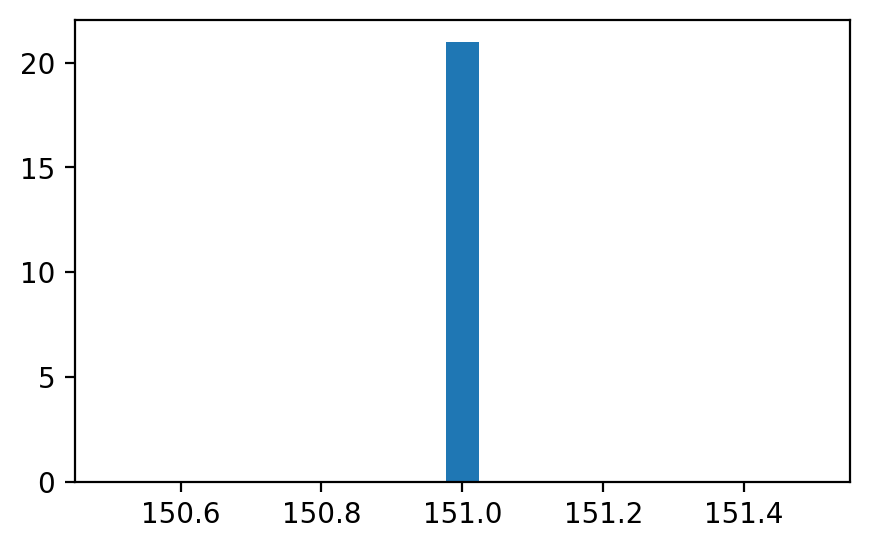

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(quality.read_length, bins=21, density=True)

(array([9.38882465e-05, 0.00000000e+00, 0.00000000e+00, 1.00271078e-04,
        0.00000000e+00, 1.14997234e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.78801606e-03, 0.00000000e+00,
        0.00000000e+00, 9.01829948e-03, 0.00000000e+00, 0.00000000e+00,
        2.38150586e-02, 0.00000000e+00, 5.56878897e-02, 0.00000000e+00,
        4.32458392e-01]),
 array([ 2.        ,  3.85714286,  5.71428571,  7.57142857,  9.42857143,
        11.28571429, 13.14285714, 15.        , 16.85714286, 18.71428571,
        20.57142857, 22.42857143, 24.28571429, 26.14285714, 28.        ,
        29.85714286, 31.71428571, 33.57142857, 35.42857143, 37.28571429,
        39.14285714, 41.        ]),
 <BarContainer object of 21 artists>)

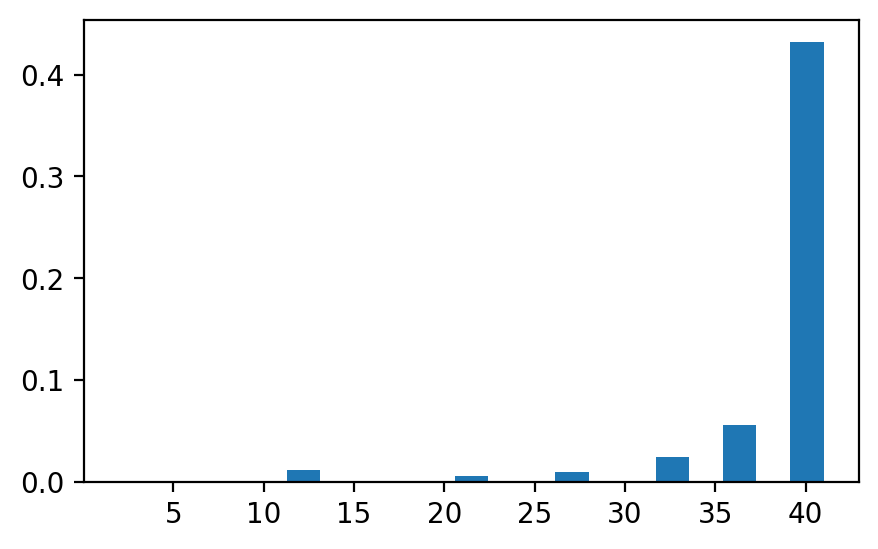

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(quality.base_quality, bins=21, density=True)

(array([0.02518849, 0.00068247, 0.00037798, 0.00062647, 0.00054948,
        0.00060898, 0.00044098, 0.00074547, 0.00064747, 0.00064397,
        0.00073147, 0.00082247, 0.00079447, 0.00052848, 0.00123895,
        0.00097296, 0.00072797, 0.00099396, 0.00062298, 0.00047948,
        0.31157504]),
 array([ 0.        ,  2.85714286,  5.71428571,  8.57142857, 11.42857143,
        14.28571429, 17.14285714, 20.        , 22.85714286, 25.71428571,
        28.57142857, 31.42857143, 34.28571429, 37.14285714, 40.        ,
        42.85714286, 45.71428571, 48.57142857, 51.42857143, 54.28571429,
        57.14285714, 60.        ]),
 <BarContainer object of 21 artists>)

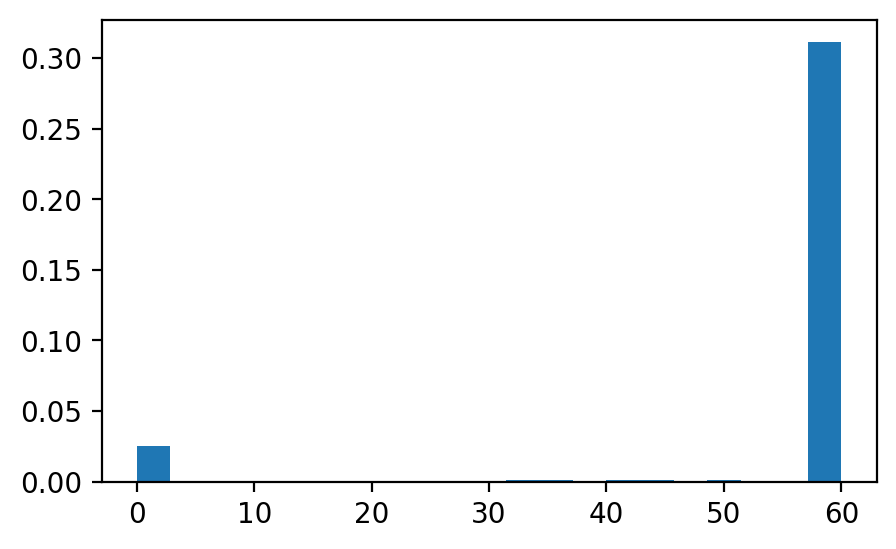

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(quality.map_quality, bins=21, density=True)

<BarContainer object of 10 artists>

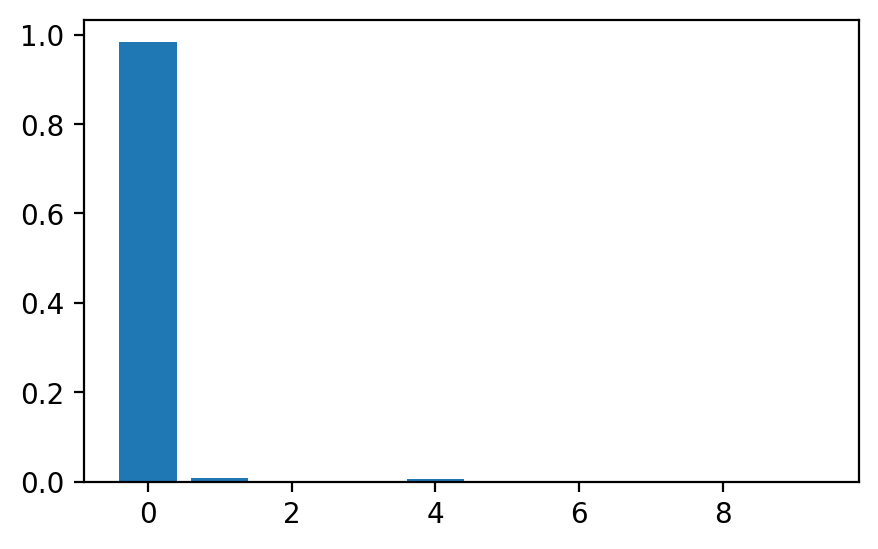

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
prop = quality.ncigars/quality.ncigars.sum()
ax.bar(range(len(prop)), prop)

## pan-gene meth

### gene sampling

In [67]:
gtffile = 'genome/gencode.v45.basic.annotation.gff3.gz'
genes = genesGenerator(gtffile)

genes_coding = []
genes_lnc = []
genes_non = []
for g in genes:
    if g.end - g.start <= 100: continue # filter short genes
    if g.biotype == 'protein_coding': 
        genes_coding.append(g)
    elif g.biotype == 'lncRNA':
        genes_lnc.append(g)
    else:
        genes_non.append(g)

def sampleGenes(l: list, k:int = 1000):
    k = min(k, len(l))
    s = random.sample(range(len(l)), k)
    s.sort()
    return [l[i] for i in s]

genes_coding_sampling = sampleGenes(genes_coding, k=1000)
genes_lnc_sampling = sampleGenes(genes_lnc, k=1000)
genes_non_sampling = sampleGenes(genes_non, k=2000)


In [68]:
len(genes_coding), len(genes_lnc), len(genes_non)

(20027, 19363, 20631)

### lncRNA genes

In [69]:
# lncRNA
cov_pangene_lnc = CovPanGene()
for i in tqdm.trange(len(genes_lnc_sampling)):
    bam.update_pangene(cov_pangene_lnc, genes_lnc_sampling[i], params=params)


100%|██████████| 1000/1000 [07:49<00:00,  2.13it/s]


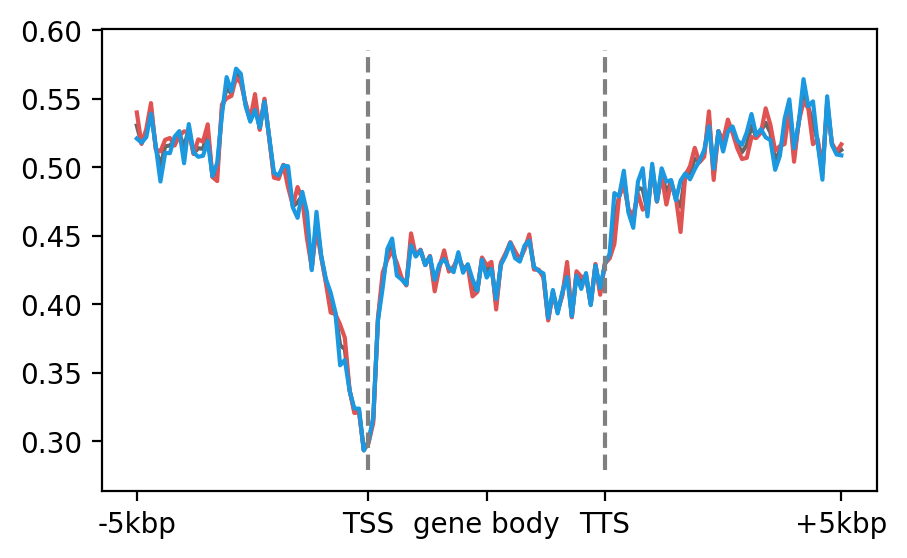

In [89]:
cov_pangene = cov_pangene_lnc

fig, ax = plt.subplots(figsize=(5,3))
x = np.arange(gene_breaks*3)
y = cov_pangene.meCG/cov_pangene.nCG
ax.plot(x, y, '-', c=COL_gray)
ax.plot(x, cov_pangene.meCGW/cov_pangene.nCGW, '-', c=COLS[1])
ax.plot(x, cov_pangene.meCGC/cov_pangene.nCGC, '-', c=COLS[0])
ax.vlines((49, 99), ax.get_ylim()[0], ax.get_ylim()[1], color= 'gray', linestyles='dashed')
plt.xticks([0, 49, 74, 99, 149], labels=['-5kbp', 'TSS', 'gene body', 'TTS', '+5kbp'])

filename = f'img/pan-gene-meth-lncRNA'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### coding genes

In [71]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()

# coding
cov_pangene_coding = CovPanGene()
for i in tqdm.trange(len(genes_coding_sampling)):
    bam.update_pangene(cov_pangene_coding, genes_coding_sampling[i], params=params)

# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

100%|██████████| 1000/1000 [14:58<00:00,  1.11it/s]


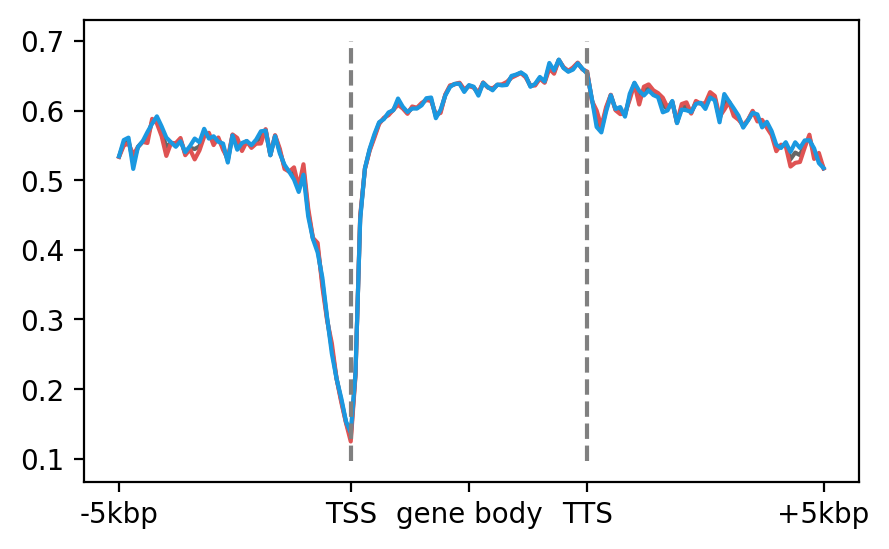

In [88]:
cov_pangene = cov_pangene_coding

fig, ax = plt.subplots(figsize=(5,3))
x = np.arange(gene_breaks*3)
y = cov_pangene.meCG/cov_pangene.nCG
ax.plot(x, y, '-', c=COL_gray)
ax.plot(x, cov_pangene.meCGW/cov_pangene.nCGW, '-', c=COLS[1])
ax.plot(x, cov_pangene.meCGC/cov_pangene.nCGC, '-', c=COLS[0])
ax.vlines((49, 99), ax.get_ylim()[0], ax.get_ylim()[1], color= 'gray', linestyles='dashed')
plt.xticks([0, 49, 74, 99, 149], labels=['-5kbp', 'TSS', 'gene body', 'TTS', '+5kbp'])

filename = f'img/pan-gene-meth-coding'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### other non-coding genes

In [73]:
# noncoding
cov_pangene_non = CovPanGene()
for i in tqdm.trange(len(genes_non_sampling)):
    bam.update_pangene(cov_pangene_non, genes_non_sampling[i], params=params)


100%|██████████| 2000/2000 [05:16<00:00,  6.32it/s]


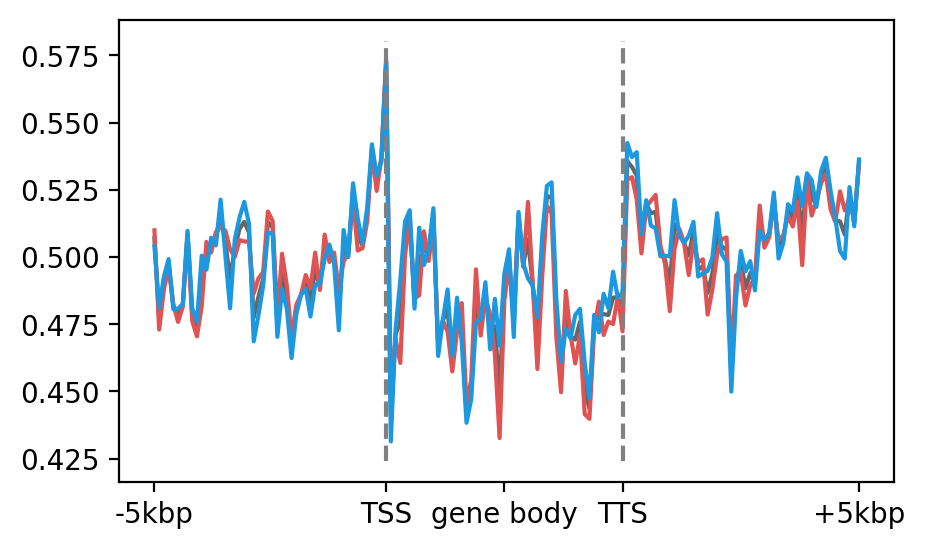

In [87]:
cov_pangene = cov_pangene_non

fig, ax = plt.subplots(figsize=(5,3))
x = np.arange(gene_breaks*3)
y = cov_pangene.meCG/cov_pangene.nCG

ax.plot(x, y, '-', c=COL_gray)
ax.plot(x, cov_pangene.meCGW/cov_pangene.nCGW, '-', c=COLS[1])
ax.plot(x, cov_pangene.meCGC/cov_pangene.nCGC, '-', c=COLS[0])
# ax.vlines((49, 99), min(y)-0.05, max(y)+0.05, color= 'gray', linestyles='dashed')
ax.vlines((49, 99), ax.get_ylim()[0], ax.get_ylim()[1], color= 'gray', linestyles='dashed')
plt.xticks([0, 49, 74, 99, 149], labels=['-5kbp', 'TSS', 'gene body', 'TTS', '+5kbp'])

filename = f'img/pan-gene-meth-other-noncoding'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## MT

In [43]:
## lambda DNA
dict_MT = CovLambda(contig='MT')
intervals = iter(GenomicIntervalGenerator(
    fa, 
    chrs= 'chrM', 
    start = 0,
    end = math.inf,
    step=5_000,
    # step=fa.get_reference_length('chrM'),
    spacing=0
    )) # type: ignore

intervals_list = list(intervals)
for i in tqdm.trange(len(intervals_list)):
    detailedIntvl = bam.detailedCoverageContig(intervals_list[i], params)
    update_lambda(dict_MT, detailedIntvl)

100%|██████████| 4/4 [03:21<00:00, 50.37s/it]


In [25]:
# dict_MT.__dict__

{'length': array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
  

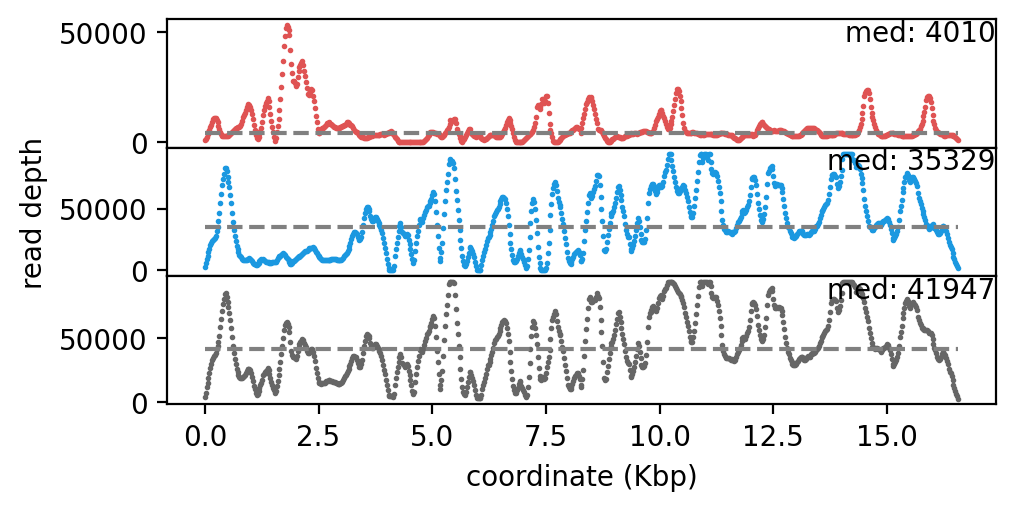

In [58]:
# binning coverage
x = np.arange(binsContig['MT'])*binSizeContig['MT']
x, prefix = prefixBpSize(x)

yw = dict_MT.dpW/dict_MT.length
yc = dict_MT.dpC/dict_MT.length
yd = dict_MT.dp/dict_MT.length
ylim = np.quantile(np.block([yw,yc]), 0.99)

figheight = 3*0.5 + 1
figwidth = len(x)/200 + 1 + 0.2

fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(figwidth, figheight))
fig.subplots_adjust(hspace=0)

axs[0].plot(x, np.repeat(np.median(yw), len(x)), '--', c='gray')
axs[0].scatter(x, np.fmin(ylim, yw), c=COLS[1], s=1)
ax.set_xlim(0, max(x))
ax.set_ylim(0, ylim)
axs[0].text(axs[0].get_xlim()[1], axs[0].get_ylim()[1], f'med: {np.median(yw):.0f}', horizontalalignment='right', verticalalignment='top')

axs[1].plot(x, np.repeat(np.median(yc), len(x)), '--', c='gray')
axs[1].scatter(x, np.fmin(ylim, yc), c=COLS[0], s=1)
ax.set_xlim(0, max(x))
ax.set_ylim(0, ylim)
axs[1].text(axs[1].get_xlim()[1], axs[1].get_ylim()[1], f'med: {np.median(yc):.0f}', horizontalalignment='right', verticalalignment='top')
axs[1].set_ylabel(f'read depth')

axs[2].plot(x, np.repeat(np.median(yd), len(x)), '--', c='gray')
axs[2].scatter(x, np.fmin(ylim, yd), c=COL_gray, s=1)
ax.set_xlim(0, max(x))
axs[2].text(axs[2].get_xlim()[1], axs[2].get_ylim()[1], f'med: {np.median(yd):.0f}', horizontalalignment='right', verticalalignment='top')

plt.xlabel(f'coordinate ({prefix})')

filename = f'img/depth-bin-MT'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [29]:
## conversion rate by MT
bs_rate_MT = 1 - dict_MT.meC/dict_MT.covnC
dp_MT = dict_MT.dp/dict_MT.length
dict_MT.length.sum(), dict_MT.cov.sum(), np.mean(dp_MT), np.median(dp_MT), bs_rate_MT

(16568, 16568, 45919.6028520235, 41947.2, 0.9901526694860165)

In [30]:
## MT DNA copy number 
np.median(dp_MT) / 60 *2

1398.24

In [40]:
## eror rate by MT
i = dict_MT.dp20 > 0
error_rate_MT = np.median(dict_MT.misbase[i]/dict_MT.dp20[i])
error_rate_MT

0.10063873207328936

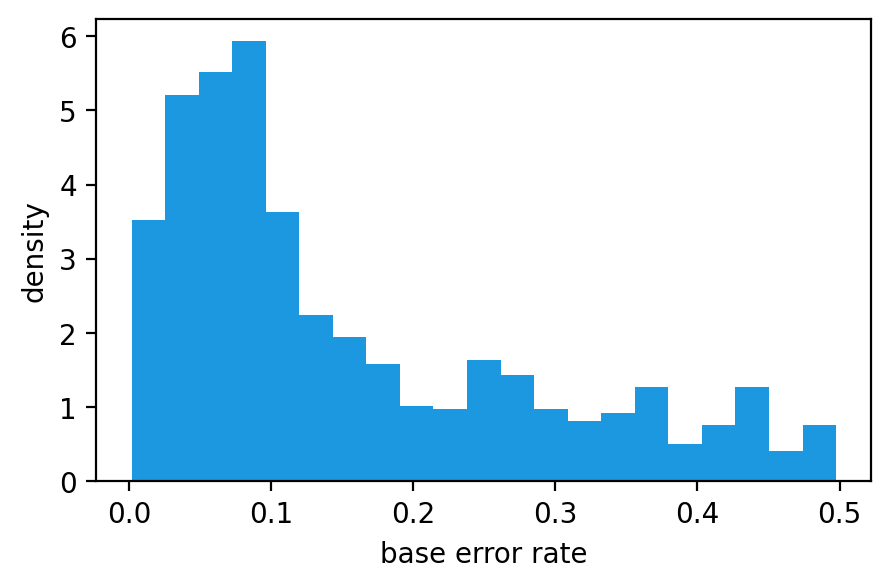

In [63]:
fig, ax = plt.subplots(figsize=(5,3))
if np.sum(dict_MT.dp20 > 0) > 0:
    ax.hist(nandivide(dict_MT.misbase, dict_MT.dp20), bins=21, density=True, color=COLS[0])
    plt.xlabel('base error rate')
    plt.ylabel('density')

    filename = f'img/base-error-rate-dist-MT'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## lambda DNA

In [22]:
## lambda DNA
dict_lambda = CovLambda(contig='lambda')
intervals = iter(GenomicIntervalGenerator(
    fa, 
    chrs= 'chrL', 
    start = 0,    
    end = math.inf,
    step=5_000,
    spacing=0
    )) # type: ignore

intervals_list = list(intervals)
for i in tqdm.trange(len(intervals_list)):
    detailedIntvl = bam.detailedCoverageContig(intervals_list[i], params)
    update_lambda(dict_lambda, detailedIntvl)

100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


In [ ]:
# dict_lambda.__dict__

In [31]:
f'median: {np.median(yw):.0f}'

'median: 1944'

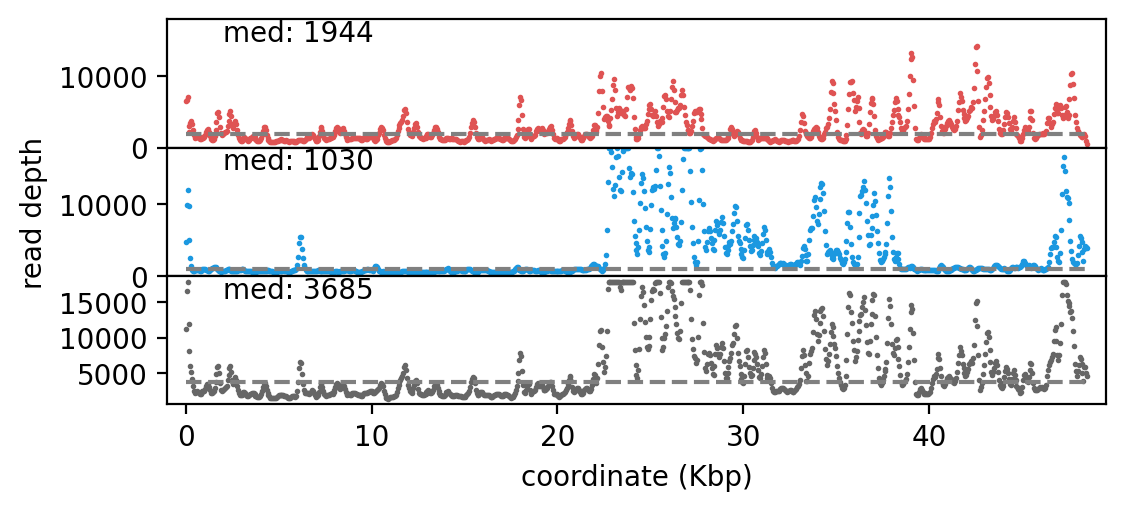

In [57]:
# binning coverage
x = np.arange(binsContig['lambda'])*binSizeContig['lambda']
x, prefix = prefixBpSize(x)

yw = dict_lambda.dpW/dict_lambda.length
yc = dict_lambda.dpC/dict_lambda.length
yd = dict_lambda.dp/dict_lambda.length
ylim = np.quantile(np.block([yw,yc]), 0.99)

figheight = 3*0.5 + 1
figwidth = len(x)/200 + 1 + 0.2

fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(figwidth, figheight))
fig.subplots_adjust(hspace=0)
plt.xlim(-1, max(x)+1)

axs[0].plot(x, np.repeat(np.median(yw), len(x)), '--', c='gray')
axs[0].scatter(x, np.fmin(ylim, yw), c=COLS[1], s=1)
axs[0].set_ylim(0, ylim)
axs[0].text(2, axs[0].get_ylim()[1], f'med: {np.median(yw):.0f}', horizontalalignment='left', verticalalignment='top')

axs[1].plot(x, np.repeat(np.median(yc), len(x)), '--', c='gray')
axs[1].scatter(x, np.fmin(ylim, yc), c=COLS[0], s=1)
axs[1].set_ylim(0, ylim)
axs[1].text(2, axs[1].get_ylim()[1], f'med: {np.median(yc):.0f}', horizontalalignment='left', verticalalignment='top')
axs[1].set_ylabel('read depth')

axs[2].plot(x, np.repeat(np.median(yd), len(x)), '--', c='gray')
axs[2].scatter(x, np.fmin(ylim, yd), c=COL_gray, s=1)
axs[2].text(2, axs[2].get_ylim()[1], f'med: {np.median(yd):.0f}', horizontalalignment='left', verticalalignment='top')

plt.xlabel(f'coordinate ({prefix})')

filename = f'img/depth-bin-lambda'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [ ]:
bs_rate_lambda = 1 - dict_lambda.meC/dict_lambda.covnC
dp_lambda = dict_lambda.dp/dict_lambda.length
dict_lambda.length.sum(), dict_lambda.cov.sum(), np.mean(dp_lambda), np.median(dp_lambda), bs_rate_lambda

(48502, 48502, 5945.246735324408, 3684.84, 0.9901022021143293)

In [ ]:
# base error rate by lambda DNA
i = dict_lambda.dp20 > 0
error_rate_lambda = np.median(dict_lambda.misbase[i]/dict_lambda.dp20[i])
error_rate_lambda

0.3064093445178278

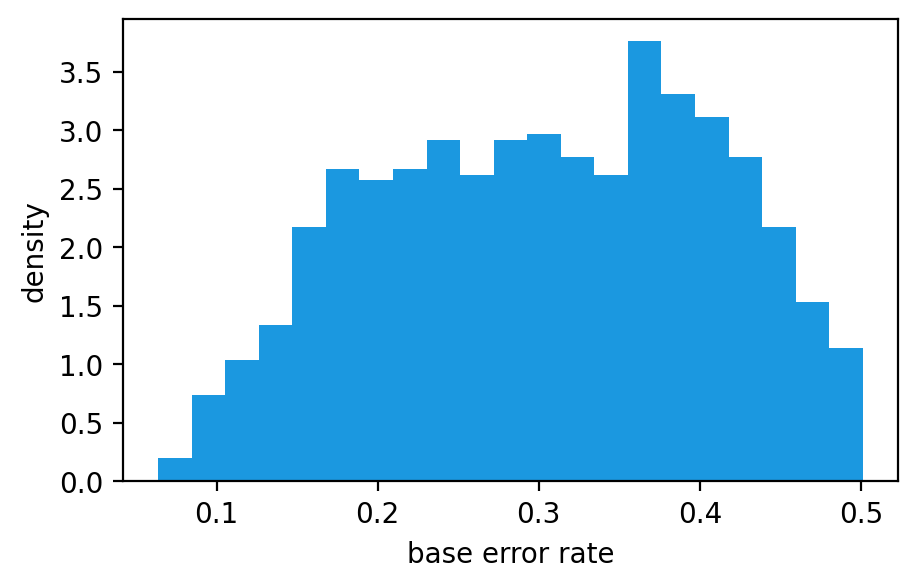

In [66]:
fig, ax = plt.subplots(figsize=(5,3))
if np.sum(dict_lambda.dp20 > 0) > 0:
    ax.hist(nandivide(dict_lambda.misbase, dict_lambda.dp20), bins=21, density=True, color=COLS[0])
    plt.xlabel('base error rate')
    plt.ylabel('density')

    filename = f'img/base-error-rate-dist-dict-lambda'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Sample nuclear genome

- according to chrs in .fa or
- according to chrs in header of .bam 

In [22]:
## nuclear chrs
testchr = 'chr18'
testchrs = 'chr18,chr19'
intervals = iter(GenomicIntervalGenerator(
    fa, 
    chrs= testchrs,
    start = 0,    
    end = math.inf,
    step=1_000,
    spacing=10_000
    )) # type: ignore

intervals_list = list(intervals)
for i in tqdm.trange(len(intervals_list)):
    detailedIntvl = bam.detailedCoverage(intervals_list[i], params)
    update_cgkmer(detailedIntvl)
    # update_binning(detailedIntvl)

100%|██████████| 12523/12523 [03:40<00:00, 56.68it/s]


In [26]:
dict_cgkmer['CCCGGG'].__dict__

{'n': 5101,
 'nW': 2551,
 'nC': 2550,
 'dp': 47192,
 'dpW': 24016,
 'dpC': 23176,
 'cov': array([4531, 3860, 3274, 2820, 2489, 2216, 1992, 1838, 1716, 1605, 1513,
        1442, 1394, 1326, 1243, 1175, 1108, 1044,  983,  919,  857,  785,
         714,  654,  591,  536,  482,  431,  384,  343,  299,  253,  226,
         205,  186,  167,  150,  136,  125,  111,  101,   86,   75,   65,
          56,   48,   41,   31,   27,   24,   23,   20,   18,   17,   15,
          12,   11,    9,    9,    7,    5,    5,    5,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
           4,    4,    4,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    2,    2,    2,    2,    2,    2,
           2,    2,    

In [ ]:
# dict_binning[('chr19', 124)].__dict__

## From genome binning

### Whole-genome summary

In [79]:
# Whole-genome

length = []
totalDepth = []
totalDepthW = []
totalDepthC = []
binning_depth = []
binning_depthW = []
binning_depthC = []
binning_cov = []
binning_covW = []
binning_covC = []

stranded_CG_depth = 0
stranded_CG_meth = 0
CGmeth_diff_by_depth = 0

# whole-genome counts
meCG: NDArray = 0
meCGW: NDArray = 0
meCGC: NDArray = 0
meCHG: NDArray = 0
meCHGW: NDArray = 0
meCHGC: NDArray = 0
meCHH: NDArray = 0
meCHHW: NDArray = 0
meCHHC: NDArray = 0
covnCG: NDArray = 0
covnCGW: NDArray = 0
covnCGC: NDArray = 0
covnCHG: NDArray = 0
covnCHGW: NDArray = 0
covnCHGC: NDArray = 0
covnCHH: NDArray = 0
covnCHHW: NDArray = 0
covnCHHC: NDArray = 0
# total in genome
nCG = 0
nCGW = 0
nCGC = 0
nCHG = 0
nCHGW = 0
nCHGC = 0
nCHH = 0
nCHHW = 0
nCHHC = 0
ATdp = []
misbase = []
nCGMethBin = 0
nCHGMethBin = 0
nCHHMethBin = 0

for key, value in dict_binning.items():
    length.append(value.length)
    totalDepth.append(value.dp)
    totalDepthW.append(value.dpW)
    totalDepthC.append(value.dpC)
    binning_depth.append(-np.diff(np.block([value.cov, 0])))
    binning_depthW.append(-np.diff(np.block([value.covW, 0])))
    binning_depthC.append(-np.diff(np.block([value.covC, 0])))
    binning_cov.append(value.cov)
    binning_covW.append(value.covW)
    binning_covC.append(value.covC)
    stranded_CG_depth += value.stranded_CG_depth
    stranded_CG_meth += value.stranded_CG_meth
    CGmeth_diff_by_depth += value.CGmeth_diff_by_depth
    
    nCG += value.nCG
    nCGW += value.nCGW
    nCGC += value.nCGC
    nCHG += value.nCHG
    nCHGW += value.nCHGW
    nCHGC += value.nCHGC
    nCHH += value.nCHH
    nCHHW += value.nCHHW
    nCHHC += value.nCHHC
    covnCG += value.covnCG
    covnCGW += value.covnCGW
    covnCGC += value.covnCGC
    covnCHG += value.covnCHG
    covnCHGW += value.covnCHGW
    covnCHGC += value.covnCHGC
    covnCHH += value.covnCHH
    covnCHHW += value.covnCHHW
    covnCHHC += value.covnCHHC
    meCG += value.meCG
    meCGW += value.meCGW
    meCGC += value.meCGC
    meCHG += value.meCHG
    meCHGW += value.meCHGW
    meCHGC += value.meCHGC
    meCHH += value.meCHH
    meCHHW += value.meCHHW
    meCHHC += value.meCHHC
    ATdp.append(value.ATdp)
    misbase.append(value.misbase)
    nCGMethBin += value.nCGMethBin
    nCHGMethBin += value.nCHGMethBin
    nCHHMethBin += value.nCHHMethBin

length = np.asarray(length)
binning_depth = np.asarray(binning_depth)
binning_depthW = np.asarray(binning_depthW)
binning_depthC = np.asarray(binning_depthC)
binning_cov = np.asarray(binning_cov)
binning_covW = np.asarray(binning_covW)
binning_covC = np.asarray(binning_covC)
# whole-genome cov
genome_cov = np.sum(binning_cov, axis=0)
genome_covW = np.sum(binning_covW, axis=0)
genome_covC = np.sum(binning_covC, axis=0)

totalDepth = np.asarray(totalDepth)
totalDepthW = np.asarray(totalDepthW)
totalDepthC = np.asarray(totalDepthC)
totalBases = totalDepth.sum()
totalBasesW = totalDepthW.sum()
totalBasesC = totalDepthC.sum()
ATdp =  np.asarray(ATdp)
misbase = np.asarray(misbase)

# define DP threshold
prop_CG = covnCG/covnCG[0]
DP_xdepth = MAXDEPTH -1 - np.argmax(prop_CG[::-1] >= 0.03)

gen = np.random.Generator(np.random.PCG64())


In [25]:
# culmuative meth
# dict_genome_me = {
#     'CG': {'double': nandivide(meCG,covnCG), 'W': nandivide(meCGW,covnCGW), 'C': nandivide(meCGC,covnCGC)},
#     'CHG': {'double': nandivide(meCHG,covnCHG), 'W': nandivide(meCHGW,covnCHGW), 'C': nandivide(meCHGC,covnCHGC)},
#     'CHH': {'double': nandivide(meCHH,covnCHH), 'W': nandivide(meCHHW,covnCHHW), 'C': nandivide(meCHHC,covnCHHC)}
#     }

# culmulative covered Cs
dict_genome_covnC = { 
'CG': {'double': covnCG, 'W': covnCGW, 'C': covnCGC},
'CHG': {'double': covnCHG, 'W': covnCHGW, 'C': covnCHGC},
'CHH': {'double': covnCHH, 'W': covnCHHW, 'C': covnCHHC}
}

# culmulative me
dict_genome_me = { 
'CG': {'double': meCG, 'W': meCGW, 'C': meCGC},
'CHG': {'double': meCHG, 'W': meCHGW, 'C': meCHGC},
'CHH': {'double': meCHH, 'W': meCHHW, 'C': meCHHC}
}

# genome Cs
dict_Cs = {
    'CG':{'double': nCG, 'W': nCGW, 'C': nCGC},
    'CHG':{'double': nCHG, 'W': nCHGW, 'C': nCHGC},
    'CHH':{'double': nCHH, 'W': nCHHW, 'C': nCHHC}
}


### chromosome-wise stats

In [26]:
# bin-wise
dict_bin_meCG = dict()
dict_bin_meCGW = dict()
dict_bin_meCGC = dict()
dict_bin_meCHG = dict()
dict_bin_meCHGW = dict()
dict_bin_meCHGC = dict()
dict_bin_meCHH = dict()
dict_bin_meCHHW = dict()
dict_bin_meCHHC = dict()
dict_bin_dp = dict()
dict_bin_dpW = dict()
dict_bin_dpC = dict()
DP_valid = 30


In [27]:
chrs_valid = []
lens_valid = []
for i, chr in enumerate(fa.references):
    if not chr.endswith(('_random', '_alt')) and not chr.startswith('chrUn_') and chr not in ['chrL', 'chrM']:
        chrs_valid.append(chr)
        lens_valid.append(fa.lengths[i])
        nbin = int(np.ceil(fa.lengths[i]/binSize))
        dict_bin_meCG[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCGW[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCGC[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHG[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHGW[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHGC[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHH[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHHW[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHHC[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_dp[chr] = np.zeros((nbin, ), dtype=float)
        dict_bin_dpW[chr] = np.zeros((nbin, ), dtype=float)
        dict_bin_dpC[chr] = np.zeros((nbin, ), dtype=float)

lens_valid = np.array(lens_valid)

In [28]:
# chromosome-wise
# sum of meth
dict_chr_meCG = dict.fromkeys(chrs_valid, 0)
dict_chr_meCGW = dict.fromkeys(chrs_valid, 0)
dict_chr_meCGC = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHG = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHGW = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHGC = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHH = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHHW = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHHC = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHG = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHGW = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHGC = dict.fromkeys(chrs_valid, 0)
# covnCG
dict_chr_covnCG = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCGW = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCGC = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHG = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHGW = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHGC = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHH = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHHW = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHHC = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHG = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHGW = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHGC = dict.fromkeys(chrs_valid, 0)

In [29]:
for key, value in dict_binning.items():
    chr, bin = key
    if chr not in chrs_valid: continue

    # meth CG
    index = value.covnCG[:DP_valid] >= 1
    dict_bin_meCG[chr][bin, index] = value.meCG[:DP_valid][index]/value.covnCG[:DP_valid][index]
    dict_bin_meCG[chr][bin, ~index] = np.nan
    # meth CG W
    index = value.covnCGW[:DP_valid] >= 1
    dict_bin_meCGW[chr][bin, index] = value.meCGW[:DP_valid][index]/value.covnCGW[:DP_valid][index]
    dict_bin_meCGW[chr][bin, ~index] = np.nan
    # meth CG C
    index = value.covnCGC[:DP_valid] >= 1
    dict_bin_meCGC[chr][bin, index] = value.meCGC[:DP_valid][index]/value.covnCGC[:DP_valid][index]
    dict_bin_meCGC[chr][bin, ~index] = np.nan
    # meth CHG
    index = value.covnCHG[:DP_valid] >= 1
    dict_bin_meCHG[chr][bin, index] = value.meCHG[:DP_valid][index]/value.covnCHG[:DP_valid][index]
    dict_bin_meCHG[chr][bin, ~index] = np.nan
    # meth CHG W
    index = value.covnCHGW[:DP_valid] >= 1
    dict_bin_meCHGW[chr][bin, index] = value.meCHGW[:DP_valid][index]/value.covnCHGW[:DP_valid][index]
    dict_bin_meCHGW[chr][bin, ~index] = np.nan
    # meth CHG C
    index = value.covnCHGC[:DP_valid] >= 1
    dict_bin_meCHGC[chr][bin, index] = value.meCHGC[:DP_valid][index]/value.covnCHGC[:DP_valid][index]
    dict_bin_meCHGC[chr][bin, ~index] = np.nan
    # meth CHH
    index = value.covnCHH[:DP_valid] >= 1
    dict_bin_meCHH[chr][bin, index] = value.meCHH[:DP_valid][index]/value.covnCHH[:DP_valid][index]
    dict_bin_meCHH[chr][bin, ~index] = np.nan
    # meth CHH W
    index = value.covnCHHW[:DP_valid] >= 1
    dict_bin_meCHHW[chr][bin, index] = value.meCHHW[:DP_valid][index]/value.covnCHHW[:DP_valid][index]
    dict_bin_meCHHW[chr][bin, ~index] = np.nan
    # meth CHH C
    index = value.covnCHHC[:DP_valid] >= 1
    dict_bin_meCHHC[chr][bin, index] = value.meCHHC[:DP_valid][index]/value.covnCHHC[:DP_valid][index]
    dict_bin_meCHHC[chr][bin, ~index] = np.nan
    # depth
    if value.length < 0: continue
    dict_bin_dp[chr][bin] = value.dp/value.length
    dict_bin_dpW[chr][bin] = value.dpW/value.length
    dict_bin_dpC[chr][bin] = value.dpC/value.length

    ## chr-wise me
    dict_chr_meCG[chr] += value.meCG[:DP_valid]
    dict_chr_meCGW[chr] += value.meCGW[:DP_valid]
    dict_chr_meCGC[chr] += value.meCGC[:DP_valid]
    dict_chr_meCHG[chr] += value.meCHG[:DP_valid]
    dict_chr_meCHGW[chr] += value.meCHGW[:DP_valid]
    dict_chr_meCHGC[chr] += value.meCHGC[:DP_valid]
    dict_chr_meCHH[chr] += value.meCHH[:DP_valid]
    dict_chr_meCHHW[chr] += value.meCHHW[:DP_valid]
    dict_chr_meCHHC[chr] += value.meCHHC[:DP_valid]
    ## chr-wise cov
    dict_chr_covnCG[chr] += value.covnCG[:DP_valid]
    dict_chr_covnCGW[chr] += value.covnCGW[:DP_valid]
    dict_chr_covnCGC[chr] += value.covnCGC[:DP_valid]
    dict_chr_covnCHG[chr] += value.covnCHG[:DP_valid]
    dict_chr_covnCHGW[chr] += value.covnCHGW[:DP_valid]
    dict_chr_covnCHGC[chr] += value.covnCHGC[:DP_valid]
    dict_chr_covnCHH[chr] += value.covnCHH[:DP_valid]
    dict_chr_covnCHHW[chr] += value.covnCHHW[:DP_valid]
    dict_chr_covnCHHC[chr] += value.covnCHHC[:DP_valid]
    

In [30]:
dict_chr_me = {
    'CG':{'double': dict_chr_meCG,'W': dict_chr_meCGW, 'C':dict_chr_meCGC},
    'CHG':{'double': dict_chr_meCHG,'W': dict_chr_meCHGW, 'C':dict_chr_meCHGC},
    'CHH':{'double': dict_chr_meCHH,'W': dict_chr_meCHHW, 'C':dict_chr_meCHHC}
    }
dict_chr_cov = {
    'CG':{'double': dict_chr_covnCG,'W': dict_chr_covnCGW, 'C':dict_chr_covnCGC},
    'CHG':{'double': dict_chr_covnCHG,'W': dict_chr_covnCHGW, 'C':dict_chr_covnCHGC},
    'CHH':{'double': dict_chr_covnCHH,'W': dict_chr_covnCHHW, 'C':dict_chr_covnCHHC}
    }
dict_bin_me = {
    'CG':{'double': dict_bin_meCG,'W': dict_bin_meCGW, 'C':dict_bin_meCGC},
    'CHG':{'double': dict_bin_meCHG,'W': dict_bin_meCHGW, 'C':dict_bin_meCHGC},
    'CHH':{'double': dict_bin_meCHH,'W': dict_bin_meCHHW, 'C':dict_bin_meCHHC}
}
dict_bin_depth = {'double': dict_bin_dp,'W': dict_bin_dpW, 'C':dict_bin_dpC}

### Error rate

In [32]:
# error rate by A/T sites
i = ATdp >= 100
np.median(misbase[i]/ATdp[i]), np.mean(misbase[i]/ATdp[i])

(0.23426954660538085, 0.23276250118915623)

### Bisulfite coversion rate 

In [25]:
# by CHH meth weighted by dp
wdp = np.sqrt(np.arange(MAXDEPTH-1))
w = -np.diff(covnCHH)*wdp
mechh = np.sum(-np.diff(meCHH)*wdp)/w.sum()
bs_rate_chh = 1 - mechh
mechh, bs_rate_chh

(0.010053237467766627, 0.9899467625322333)

In [ ]:
# adjusted CHH meth 
# 1 - (1-mechh)/bs_rate_lambda
1 - (1-0.010737456170736626)/bs_rate_lambda

0.0008480521336816649

In [31]:
# adjusted CHG meth 
# 1 - (1-mechg)/bs_rate_lambda
1 - (1-0.45828452)/0.9901022021143293

0.45286912922404865

### Methylation distribution

In [ ]:
## methylation distribution
methDist = {'CG': nCGMethBin, 'CHG': nCHGMethBin, 'CHH': nCHHMethBin}

for key, value in methDist.items():
    count = np.cumsum(value[:,::-1], axis=1)[:,::-1]
    prop = count / np.sum(count, axis=0)
    ylim = axlimit(np.max(prop))
    shape = np.shape(prop)
    x = np.arange(shape[0])
    x2 = np.arange(0,shape[0]+1, 4)
    xlabels=x2/shape[0]
    for DP in range(shape[1]):
    # for DP in range(1):
        filename = f'meth-dist-genome-{key}-dp{DP+1}'
        fig, ax = plt.subplots(figsize=(5,2))
        ax.bar(x, prop[:,DP], width=1, align='edge', color='#1B98E0')
        ax.set_xticks(x2, xlabels)
        ax.set_ylim(0, ylim)
        ax.set_xlabel('methylation level')
        ax.set_ylabel('proportion')
        plt.savefig(filename+'.png', transparent=True, dpi=120, bbox_inches='tight')
        plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### chr-wise meth

In [ ]:
# chr-wise meth

strand = 'double'
for cg in CONTEXTS:
    chrs_plot = [chr for chr in chrs_valid if np.any(dict_chr_me[cg][strand][chr] != 0)]
    figwidth = min(12, len(chrs_plot)*0.15 + 1)
    ylim = 0
    me_list = []
    for dp in range(DP_valid):
        me = [dict_chr_me[cg][strand][chr][dp]/dict_chr_cov[cg][strand][chr][dp] for chr in chrs_plot]
        me_list.append(me)
        ylim = max(ylim, max(me))
    ylim = axlimit(ylim)
    for dp in range(DP_valid):
        fig, ax = plt.subplots(figsize = (figwidth,2))
        ax.bar(chrs_plot, me_list[dp], color=COLS[0])
        ax.set_ylim(0, ylim)
        plt.xticks(rotation=45)
        ax.set_ylabel('mean methylation')
        filename = f'img/meth-chr-{cg}-{strand}-dp{dp+1}'
        plt.savefig(filename+'.png', transparent=True, dpi=120, bbox_inches='tight')
        plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## CpG strandness

### CGs of different depths

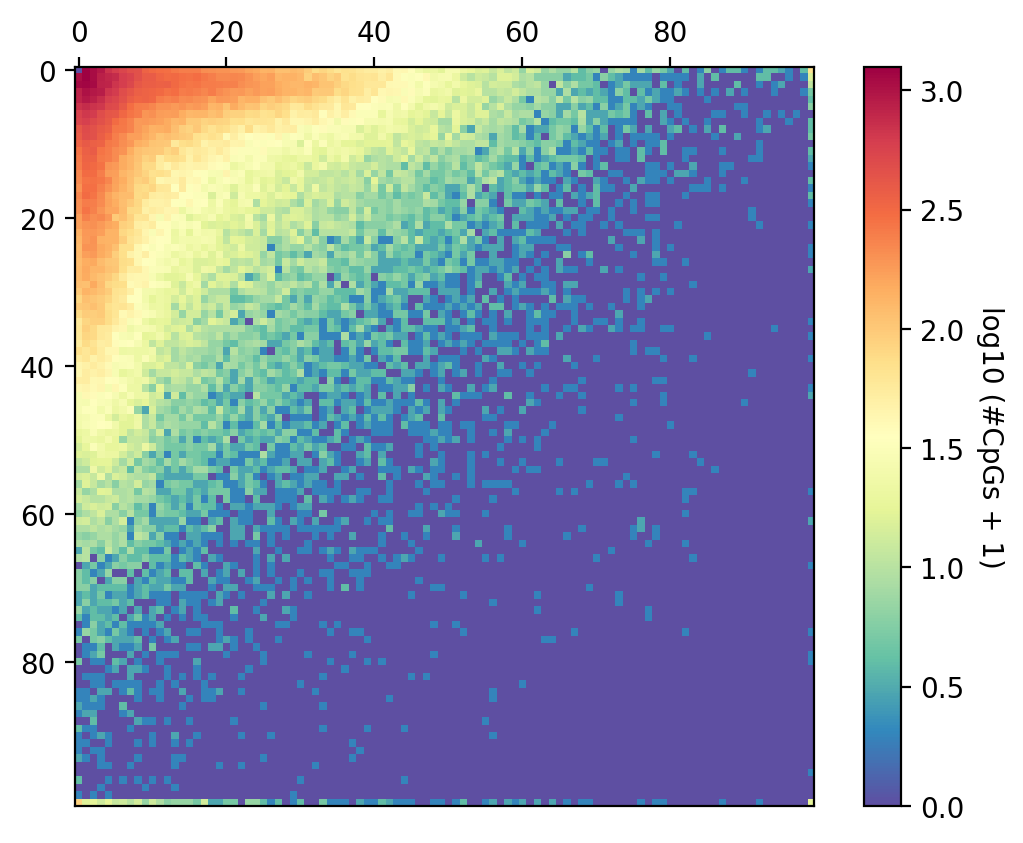

In [157]:
n = stranded_CG_depth.shape[0]
x = np.arange(5) *20

fig, ax = plt.subplots()
stranded_CG_depth[0,0] = 0
im = ax.imshow(np.log10(1+stranded_CG_depth), cmap='Spectral_r')
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticks(x, labels=x)
ax.set_yticks(x, labels=x)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('log10 (#CpGs + 1)', rotation=-90, va="bottom")

filename = f'img/heatmap-cg-stranded-depth'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### CG depth difference

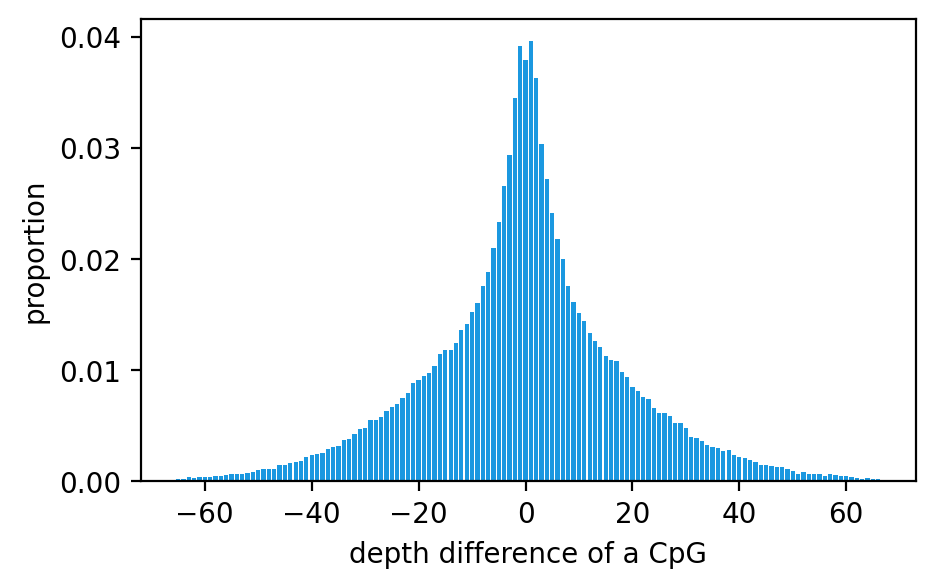

In [146]:
## CG stranded cov difference
cov_diff = np.zeros((199,), dtype=int)
shape = np.shape(stranded_CG_depth)
for i in range(shape[0]):
    for j in range(shape[1]):
        if (i,j) == (0,0): continue
        cov_diff[i-j+99] += stranded_CG_depth[i,j]
dp_diff = np.arange(-99, 100)
cov_diff = cov_diff/cov_diff.sum()

dp = min(DP_xdepth+20, 100)

fig, ax = plt.subplots(figsize=(7, 2.5))
ax.bar(dp_diff[(100-dp):(100+dp)], cov_diff[(100-dp):(100+dp)], color=COLS[0])
plt.xlabel('depth difference of a CpG')
plt.ylabel('proportion')

filename = f'img/cg-stranded-depth-difference'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [147]:
# mean/sd, M(mean)AD/sd of cov diff
a = np.inner(dp_diff, cov_diff)
sda = math.sqrt(np.inner(dp_diff**2, cov_diff) - a**2)
b = np.inner(np.abs(dp_diff), cov_diff)
sdb = math.sqrt(np.inner(dp_diff**2, cov_diff) - b**2)
a, sda, b, sdb

(-0.01446303499452125,
 19.660707195124434,
 13.93249088450719,
 13.871889357435165)

### CGs of double-stranded coverage 

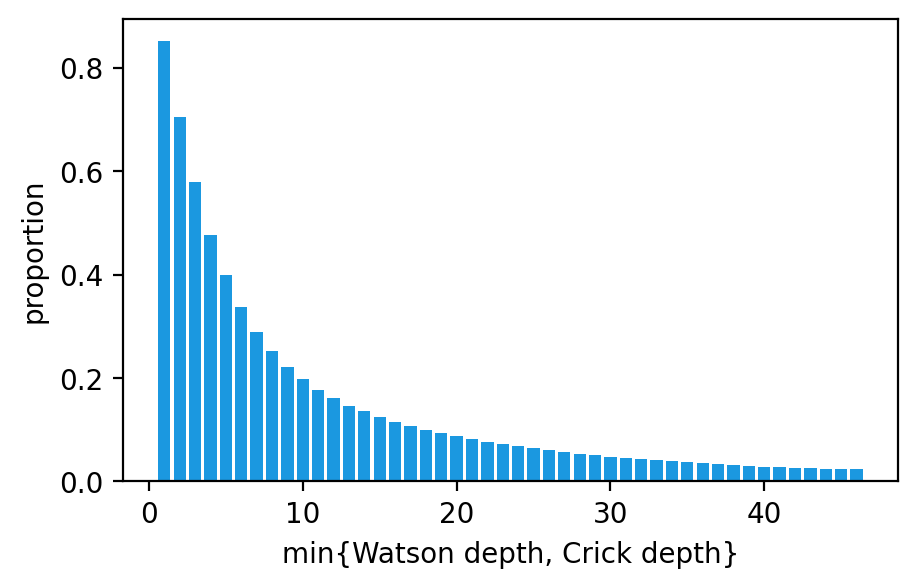

In [152]:
## CGs of double-srtanded coverage
prop_double_cov = np.zeros((DP_xdepth,))
shape = np.shape(stranded_CG_depth)
for i in np.arange(1, DP_xdepth+1):
    b = stranded_CG_depth[i:, i:].sum() # both
    a = stranded_CG_depth[i:,:].sum() + stranded_CG_depth[:,i:].sum() - b
    prop_double_cov[i-1] = b/a

fig, ax = plt.subplots(figsize=(5,3))
ax.bar(np.arange(1, DP_xdepth+1), prop_double_cov, color=COLS[0])
plt.xlabel('min{Watson depth, Crick depth}')
plt.ylabel('proportion')

filename = f'img/cg-prop-of-double-stranded-coverage'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### CG stranded meth

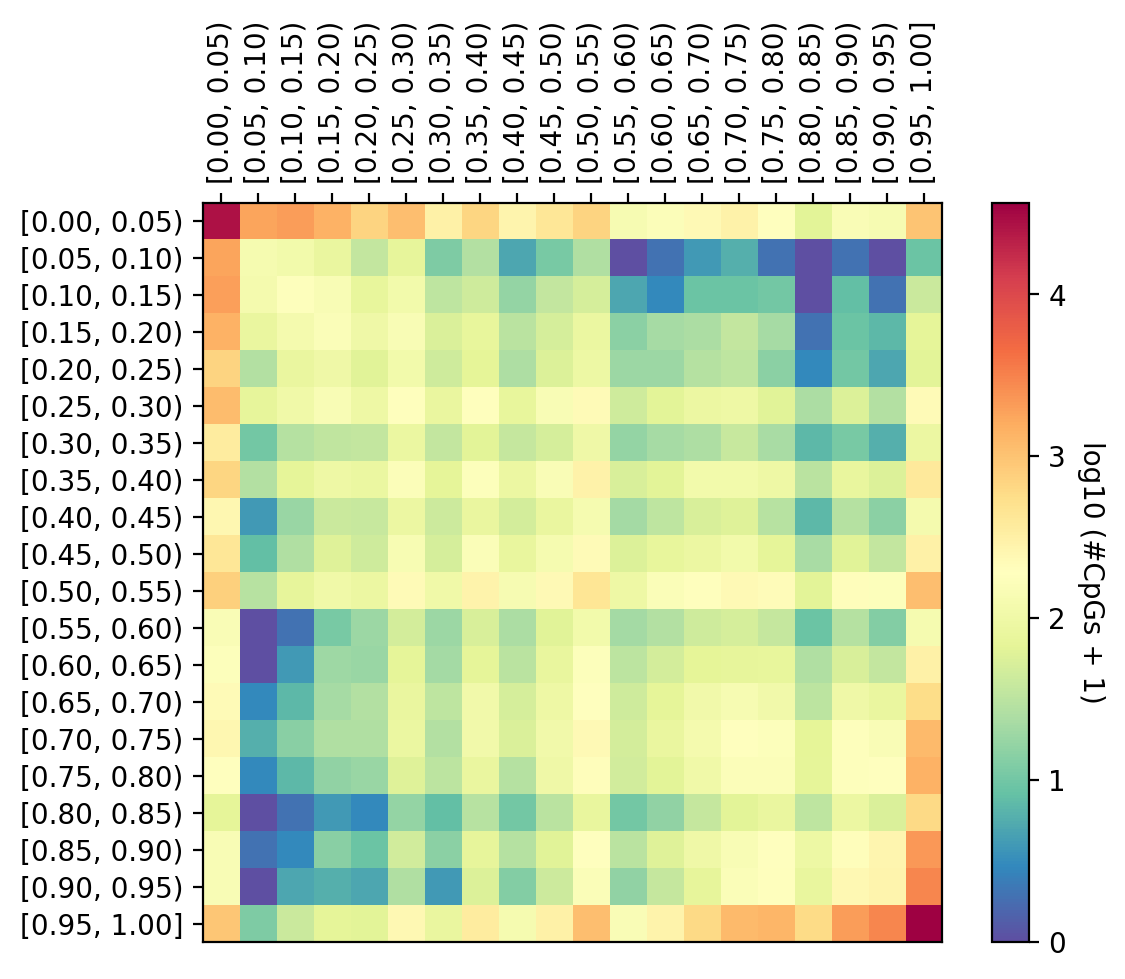

In [159]:
# DP >= 1
n = stranded_CG_meth.shape[0]
x = np.arange(n)
labels = [
    f'[{k/n:.2f}, {(k+1)/n:.2f})' 
    if k<n-1 else f'[{k/n:.2f}, {(k+1)/n:.2f}]' 
    for k in np.arange(n)
    ]
fig, ax = plt.subplots()
im = ax.imshow(np.log10(1+stranded_CG_meth), cmap='Spectral_r')
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticks(x, labels=labels)
ax.set_yticks(x, labels=labels)
ax.tick_params(axis='x', labelrotation= 90)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('log10 (#CpGs + 1)', rotation=-90, va="bottom")

filename = f'img/heatmap-cg-stranded-meth'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### heatmap of meth diff by DP

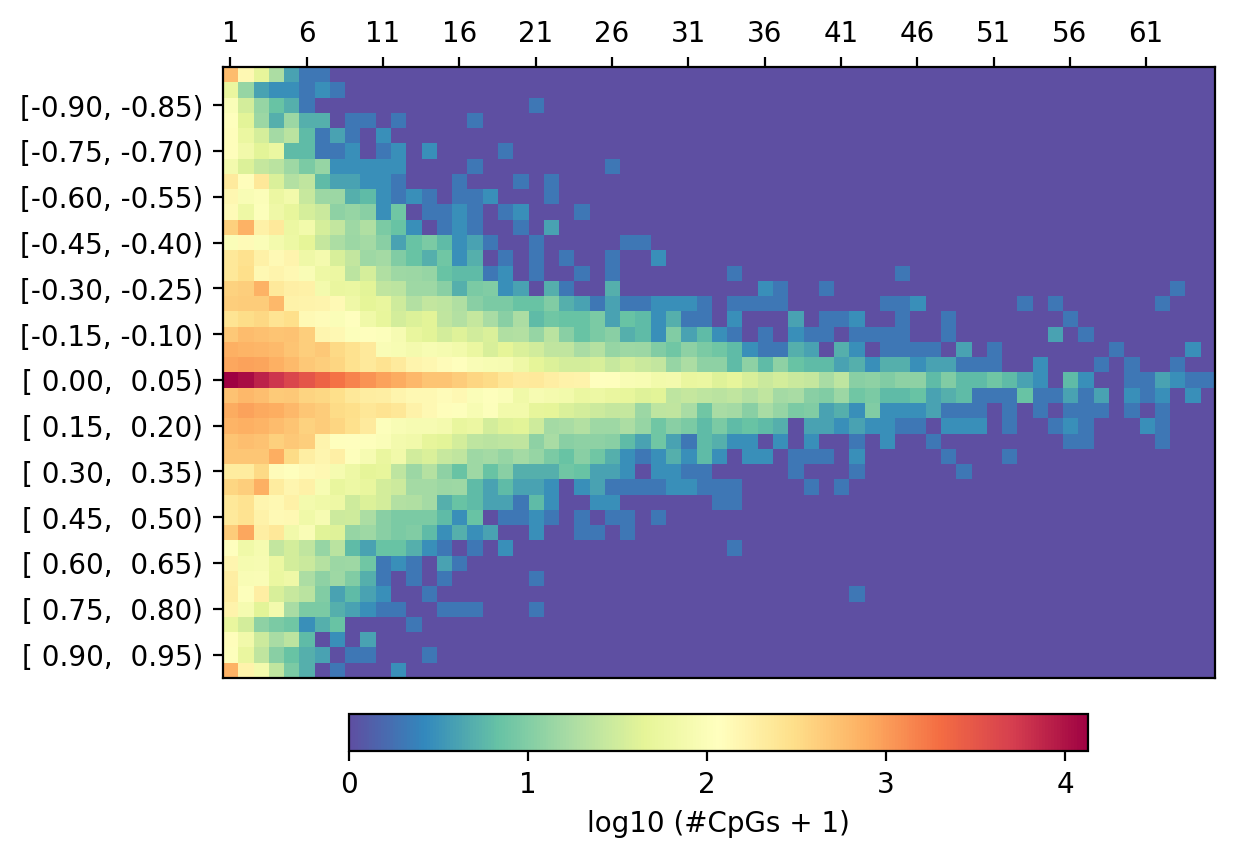

In [176]:
# DP >= 1
# n = stranded_CG_meth.shape[0]
y = np.arange(2, 40, step=3)
dp = min(100,DP_xdepth+20)
x = np.arange(dp-1, step=5)
labels = [
    f'[{k/n:5.2f}, {(k+1)/n:5.2f})' 
    if k<n-1 else f'[{k/n:5.2f}, {(k+1)/n:5.2f}]' 
    for k in np.arange(-18, 20, step=3)
    ]
fig, ax = plt.subplots()
im = ax.imshow(np.log10(1+CGmeth_diff_by_depth[:,1:dp]), cmap='Spectral_r')
# im = ax.imshow(np.log10(1+stranded_CG_meth), cmap='Spectral_r')
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_yticks(y, labels=labels)
ax.set_xticks(x, labels=x+1)
# ax.tick_params(axis='x', labelrotation= 90)
cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05)
# cbar.ax.set_ylabel('log10 (#CpGs + 1)', rotation=-90, va="bottom")
cbar.ax.set_xlabel('log10 (#CpGs + 1)')

filename = f'img/heatmap-cg-stranded-meth-diff'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Binning

### binning methylation

In [ ]:
dp = 0 # only plot depth >= 1

chrs_plot = [chr for chr in chrs_valid if np.any(dict_bin_me['CG']['double'][chr] != 0)]

for cg in CONTEXTS:
    for strand in ['double', 'single']:
        if strand == 'double':
            me = dict_bin_me[cg][strand]
            maxbins = max([me[chr].shape[0] for chr in chrs_plot])
            add = int(cg!='CG')*0.2 + int(strand=='single')*0.1
            figheight = len(chrs_plot)*0.35 + 1
            figwidth = maxbins/250 + 1 + add
        else:
            me = dict_bin_me[cg]['W']
            me2 = dict_bin_me[cg]['C']
            maxbins = max([me[chr].shape[0] for chr in chrs_plot])
            figheight = len(chrs_plot)*0.6 + 1
            figwidth = maxbins/250 + 1.2 + add

    # for dp in range(DP_valid):
        fig, axs = plt.subplots(len(chrs_plot), 1, sharex=True, sharey=True, figsize=(figwidth, figheight))
        fig.subplots_adjust(hspace=0)
        
        plt.xlim(-2, prefixBpSize(np.array([maxbins * binSize]))[0]+2)
        for i, chr in enumerate(chrs_plot):
            if i == int(len(chrs_plot)/2):
                axs[i].set_ylabel('average methylation level')
            shape = np.shape(me[chr])
            x = np.arange(shape[0]) * binSize
            x, prefix = prefixBpSize(x)
            
            # trim outliers in non-CG plots
            y = me[chr][:,dp]
            if strand == 'single':
                y2 = me2[chr][:,dp]
            if cg != 'CG':
                y = np.fmin(np.nanquantile(y, 0.99), y)
                if strand == 'single':
                    y2 = np.fmin(np.nanquantile(y, 0.99), y2)
            
            if strand == 'double':
                axs[i].scatter(x, y, s=1, c=COLS_AREA[0])
            else:
                axs[i].scatter(x, y, s=1, c=COLS_AREA[1])
                axs[i].scatter(x, -y2, s=1, c=COLS_AREA[0])
                axs[i].hlines(0, 0, max(x), color='#666666', linestyles='dashed', linewidths=1)
            if i%2 == len(chrs_plot)%2: # ensure ylabel on the left always
                axs[i].yaxis.set_label_position('right')
                axs[i].yaxis.tick_right()
            axs[i].text(axs[i].get_xlim()[1], axs[i].get_ylim()[0], chr, horizontalalignment='right', verticalalignment='bottom')
        if prefix == '':
            axs[i].set_xlabel('genome coordinate')
        else:
            axs[i].set_xlabel(f'genome coordinate ({prefix})')
        # if strand == 'single': axs[i].legend()

        filename = f'img/meth-bin-{cg}-{strand}-dp{dp+1}'
        plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
        plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### binning depth

In [ ]:

chrs_plot = [chr for chr in chrs_valid if np.any(dict_bin_depth['double'][chr] != 0)]

for strand in ['double', 'single']:
    if strand == 'double':
        dep = dict_bin_depth[strand]
        maxbins = max([dep[chr].shape[0] for chr in chrs_plot])
        add = int(strand=='single')*0.1
        figheight = len(chrs_plot)*0.4 + 1
        figwidth = maxbins/200 + 1 + add
    else:
        dep = dict_bin_depth['W']
        dep2 = dict_bin_depth['C']
        maxbins = max([dep[chr].shape[0] for chr in chrs_plot])
        figheight = len(chrs_plot)*0.7 + 1
        figwidth = maxbins/200 + 1.3 + add

    fig, axs = plt.subplots(len(chrs_plot), 1, sharex=True, sharey=True, figsize=(figwidth, figheight))
    fig.subplots_adjust(hspace=0)

    # ylim
    maxdp = np.quantile(np.hstack([np.hstack([dep[chr], dep2[chr]]) for chr in chrs_plot]), 0.98)
    for i, chr in enumerate(chrs_plot):
        if i == int(len(chrs_plot)/2):
            axs[i].set_ylabel('average read depth')
        shape = np.shape(dep[chr])
        x0 = np.arange(shape[0]) * binSize
        x, prefix = prefixBpSize(x0)
        
        # trim outliers
        y = dep[chr]
        y = np.fmin(maxdp, y)
        if strand == 'single':
            y2 = dep2[chr]
            y2 = np.fmin(maxdp, y2)
        
        if strand == 'double':
            axs[i].scatter(x, y, s=1, c=COLS_AREA[0])
        else:
            axs[i].scatter(x, y, s=1, c=COLS_AREA[1])
            axs[i].scatter(x, -y2, s=1, c=COLS_AREA[0])
            axs[i].hlines(0, 0, max(x), color='#666666', linestyles='dashed', linewidths=1)
        if i%2 == len(chrs_plot)%2: # ensure ylabel on the left always
            axs[i].yaxis.set_label_position('right')
            axs[i].yaxis.tick_right()
        axs[i].text(axs[i].get_xlim()[1], axs[i].get_ylim()[0], chr, horizontalalignment='right', verticalalignment='bottom')
    if prefix == '':
        axs[i].set_xlabel('genome coordinate')
    else:
        axs[i].set_xlabel(f'genome coordinate ({prefix})')

    filename = f'img/depth-bin-{strand}'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Meth bias

### DNAme (DP>=k) vs depth

In [ ]:
for cg in CONTEXTS:
    fig, ax = plt.subplots(figsize=(5, 3))
    x = np.arange(DP) + 1
    yd = nandivide(dict_genome_me[cg]['double'][:DP], dict_genome_covnC[cg]['double'][:DP])
    yw = nandivide(dict_genome_me[cg]['W'][:DP], dict_genome_covnC[cg]['W'][:DP])
    yc = nandivide(dict_genome_me[cg]['C'][:DP], dict_genome_covnC[cg]['C'][:DP])

    ax.plot(x, yw, '.-', c=COLS[1], markersize=5, label='Watson strand')
    ax.plot(x, yc, '.-', c=COLS[0], markersize=5, label='Crick strand')
    ax.plot(x, yd, '.-', c=COL_gray, markersize=5, label='double strands')
    ax.legend()
    ax.set_xlabel('depth threshold')
    ax.set_ylabel('methylation level')
    filename = f'img/meth-{cg}-vs-dp-threshold'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### DNAme (DP=k) vs depth

In [ ]:
for cg in CONTEXTS:
    fig, ax = plt.subplots(figsize=(5, 3))
    x = np.arange(DP) + 1
    yd = nandivide(depthDiff(dict_genome_me[cg]['double'][:DP]), 
                   depthDiff(dict_genome_covnC[cg]['double'][:DP])
                   )
    yw = nandivide(depthDiff(dict_genome_me[cg]['W'][:DP]), 
                   depthDiff(dict_genome_covnC[cg]['W'][:DP])
                   )
    yc = nandivide(depthDiff(dict_genome_me[cg]['C'][:DP]), 
                   depthDiff(dict_genome_covnC[cg]['C'][:DP])
                   )

    ax.plot(x, yw, '.-', c=COLS[1], markersize=5, label='Watson strand')
    ax.plot(x, yc, '.-', c=COLS[0], markersize=5, label='Crick strand')
    ax.plot(x, yd, '.-', c=COL_gray, markersize=5, label='double strands')
    ax.legend()
    ax.set_xlabel('depth')
    ax.set_ylabel('methylation level')
    filename = f'img/meth-{cg}-at-dp-k'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### meth vs missing rate

In [ ]:
for cg in CONTEXTS:
    fig, ax = plt.subplots(figsize=(5, 3))
    # dp = np.arange(DP) + 1
    xd = 1 - dict_genome_covnC[cg]['double'][:DP] / dict_Cs[cg]['double']
    yd = nandivide(dict_genome_me[cg]['double'][:DP], dict_genome_covnC[cg]['double'][:DP])
    xw = 1 - dict_genome_covnC[cg]['W'][:DP] / dict_Cs[cg]['W']
    yw = nandivide(dict_genome_me[cg]['W'][:DP], dict_genome_covnC[cg]['W'][:DP])
    xc = 1 - dict_genome_covnC[cg]['C'][:DP] / dict_Cs[cg]['C']
    yc = nandivide(dict_genome_me[cg]['C'][:DP], dict_genome_covnC[cg]['C'][:DP])

    ax.plot(xw, yw, '.-', c=COLS[1], markersize=5, label='Watson strand')
    ax.plot(xc, yc, '.-', c=COLS[0], markersize=5, label='Crick strand')
    ax.plot(xd, yd, '.-', c=COL_gray, markersize=5, label='double strands')
    ax.legend()
    ax.set_xlabel('depth')
    ax.set_ylabel('methylation level')
    filename = f'img/meth-{cg}-vs-missing-rate'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### coverage vs cytosine density

### meth and cov rate vs CpG density

In [ ]:
for cg in CONTEXTS:
    for strand in STRANDS:
        for dp in range(10):
            density = []
            meth = []
            density2 = [] # for cov 
            covrate = []
            for key, value in dict_binning.items():
                value = dict_binning[key]
                me = {
                    'CG': {'double': value.meCG[dp], 'W': value.meCGW[dp], 'C': value.meCGC[dp]},
                    'CHG': {'double': value.meCHG[dp], 'W': value.meCHGW[dp], 'C': value.meCHGC[dp]},
                    'CHH': {'double': value.meCHH[dp], 'W': value.meCHHW[dp], 'C': value.meCHHC[dp]}
                }
                nC = {
                    'CG': {'double': value.nCG, 'W': value.nCGW, 'C': value.nCGC},
                    'CHG': {'double': value.nCHG, 'W': value.nCHGW, 'C': value.nCHGC},
                    'CHH': {'double': value.nCHH, 'W': value.nCHHW, 'C': value.nCHHC},
                }
                covnC = {
                    'CG': {'double': value.covnCG[dp], 'W': value.covnCGW[dp], 'C': value.covnCGC[dp]},
                    'CHG': {'double': value.covnCHG[dp], 'W': value.covnCHGW[dp], 'C': value.covnCHGC[dp]},
                    'CHH': {'double': value.covnCHH[dp], 'W': value.covnCHHW[dp], 'C': value.covnCHHC[dp]},
                }
                if value.length >= 100 and value.covnCGW[dp] >= 10 and value.covnCGC[dp] >= 10 and value.covnCHGW[dp] >= 20 and value.covnCHGC[dp] >= 20 and value.covnCHHW[dp] >= 30 and value.covnCHHC[dp] >= 30:
                    density.append(nC[cg][strand] / value.length)
                    meth.append(me[cg][strand] / covnC[cg][strand])
                if value.length >= 200 and value.nCG >= 10 and value.nCHG >= 20 and value.nCHH >= 30:
                    density2.append(nC[cg][strand] / value.length)
                    covrate.append(covnC[cg][strand] / nC[cg][strand])

            density = np.asarray(density) * 1000 # density per 1000 bp
            meth = np.asarray(meth) # meth
            density2 = np.asarray(density2) * 1000
            covrate = np.asarray(covrate) # cov rate
            # sampling 2000 points
            if len(meth) > 3000:
                i = gen.choice(len(meth), size=3000, replace=False)
                density = density[i]
                meth = meth[i]

            ## meth vs density
            xy = np.vstack([density, meth])
            d = scipy.stats.gaussian_kde(xy)(xy)
            # Sort the points by density
            # so that the densest points are plotted at last
            idx = d.argsort()
            x, y, d = density[idx], meth[idx], d[idx]
            filename = f'img/meth-vs-{cg}-density-of-{strand}-strand-dp-ge{dp+1}'

            fig, ax = plt.subplots(figsize=(5, 4))
            plt.scatter(x, y, c=d, s=1, cmap='Spectral_r')
            # plt.ylim(0, 1)
            plt.xlim(np.min(density)-1, np.max(density)+1)
            plt.colorbar()
            plt.xlabel('cytosine density')
            plt.ylabel('methylation level')
            plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
            plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

            ## cov vs density
            if len(covrate) > 3000:
                i = gen.choice(len(covrate), size=3000, replace=False)
                density2 = density2[i]
                covrate = covrate[i]
            xy = np.vstack([density2, covrate])
            d = scipy.stats.gaussian_kde(xy)(xy)
            idx = d.argsort()
            x, y, d = density2[idx], covrate[idx], d[idx]
            filename = f'img/covrate-vs-{cg}-density-of-{strand}-strand-dp-ge{dp+1}'

            fig, ax = plt.subplots(figsize=(5, 4))
            plt.scatter(x, y, c=d, s=1, cmap='Spectral_r')
            # plt.ylim(0, 1)
            plt.xlim(np.min(density2)-1, np.max(density2)+1)
            plt.colorbar()
            plt.xlabel('cytosine density')
            plt.ylabel('cytosine coverage rate')
            plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
            plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')


### dp distributions of low/high meth CGs

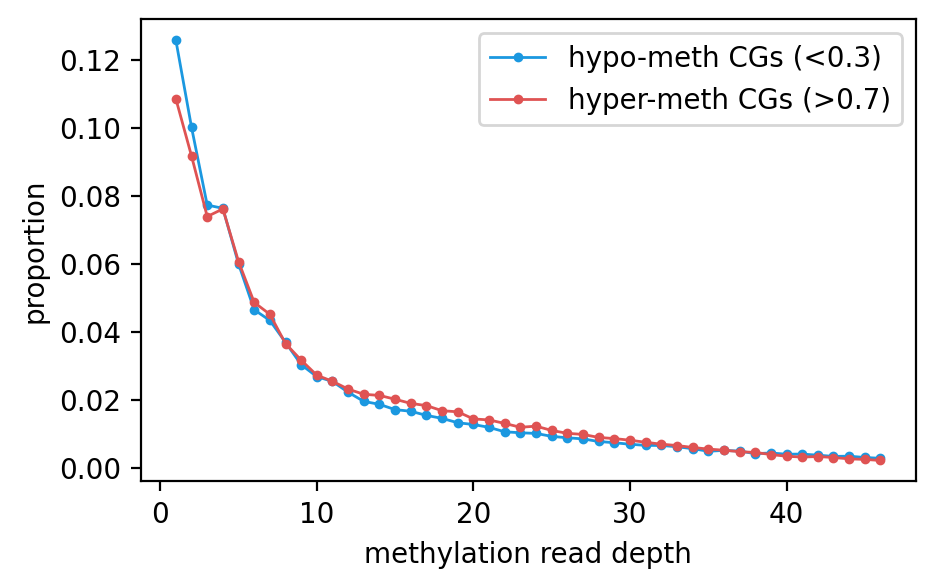

In [43]:
x = 0
y = 0
y2 = 0
ym = 0 # mean
nCGLowMeth = 0 
nCGHighMeth = 0

for key, value in dict_binning.items():
    # if chr != key[0]: continue
    value = dict_binning[key]
    nCGLowMeth += value.nCGLowMeth
    nCGHighMeth += value.nCGHighMeth

x = np.arange(DP) + 1
y = nCGLowMeth/np.sum(nCGLowMeth)
y2 = nCGHighMeth/np.sum(nCGHighMeth)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, y[:DP], '.-', c=COLS[0], linewidth=1, markersize=5, label='hypo-meth CGs (<0.3)')
ax.plot(x, y2[:DP], '.-', c=COLS[1], linewidth=1, markersize=5, label='hyper-meth CGs (>0.7)')
ax.legend()
filename = f'img/depth-of-low-high-meth-CGs'
plt.xlabel('methylation read depth')
plt.ylabel('proportion')
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Genome coverage

### CG coverage vs depth

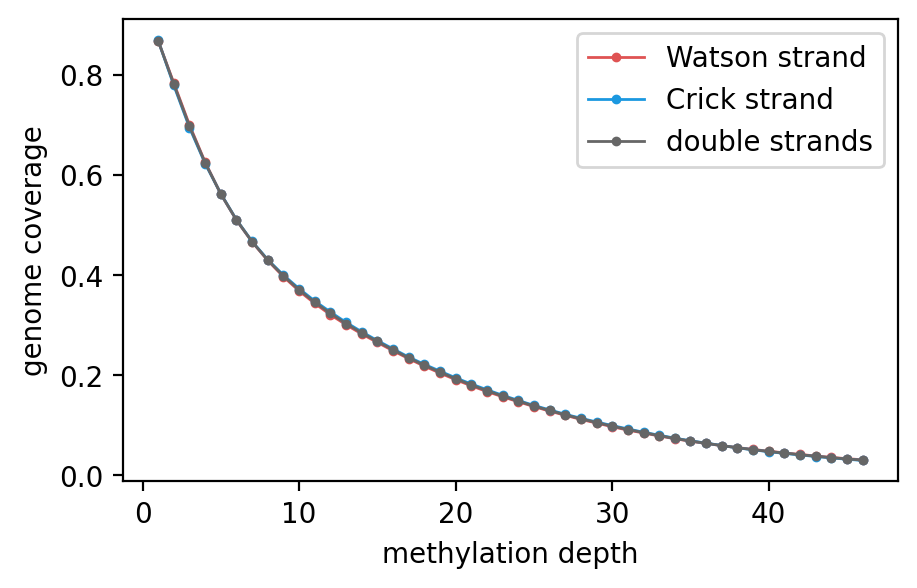

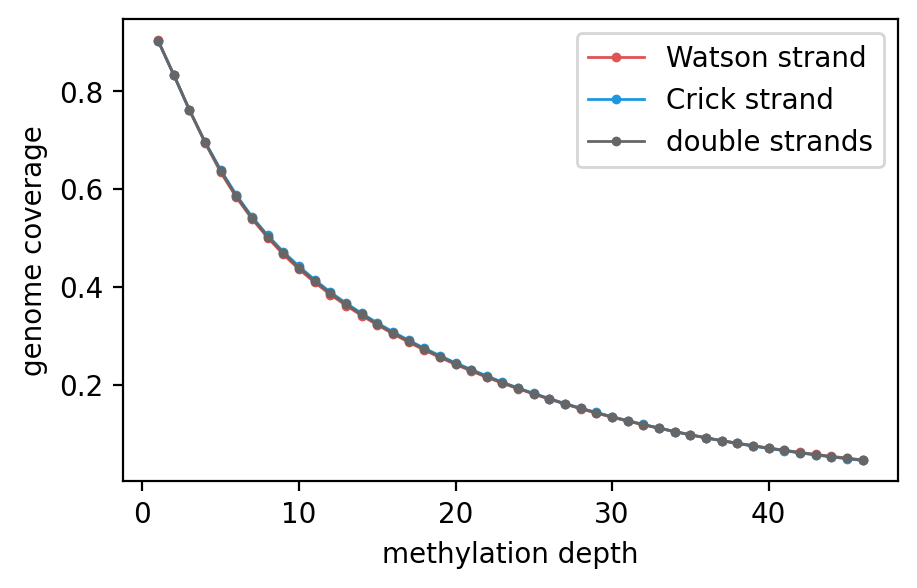

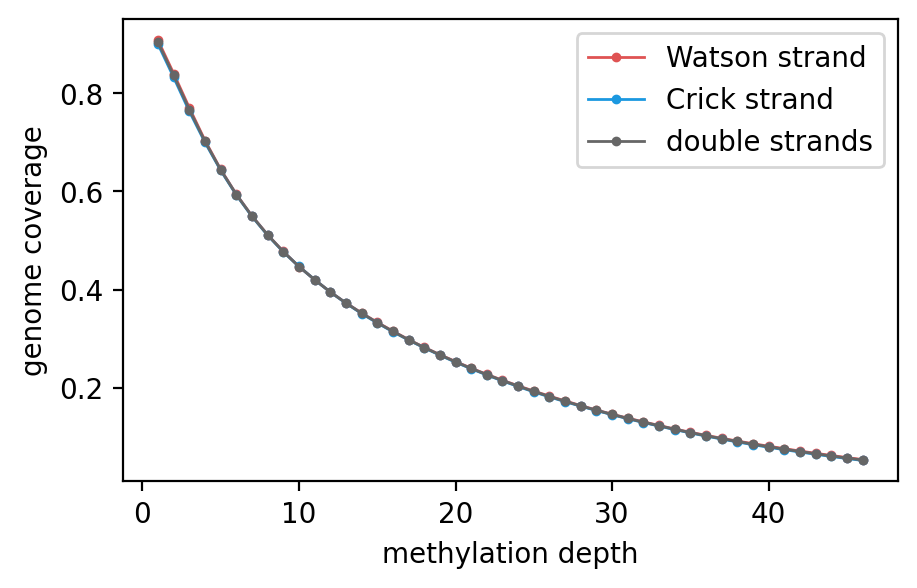

In [96]:
for cg in CONTEXTS:

    x = np.arange(DP_xdepth) + 1
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, dict_genome_covnC[cg]['W'][:DP_xdepth]/dict_Cs[cg]['W'], '.-', c=COLS[1], alpha=1, linewidth=1, markersize=5, label='Watson strand')
    ax.plot(x, dict_genome_covnC[cg]['C'][:DP_xdepth]/dict_Cs[cg]['C'], '.-', c=COLS[0], alpha=1, linewidth=1, markersize=5, label='Crick strand')
    ax.plot(x, dict_genome_covnC[cg]['double'][:DP_xdepth]/dict_Cs[cg]['double'], '.-', c=COL_gray, linewidth=1, markersize=5, label='double strands')
    ax.legend()
    plt.xlabel('methylation depth')
    plt.ylabel('genome coverage')

    filename = f'img/genome-{cg}-coverage-vs-depth'

    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### depth distribution of CGs

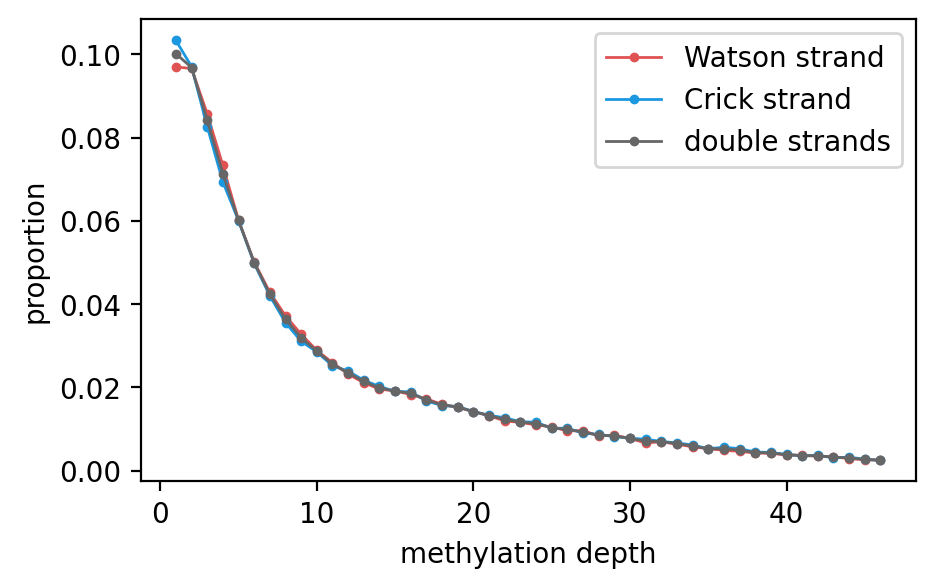

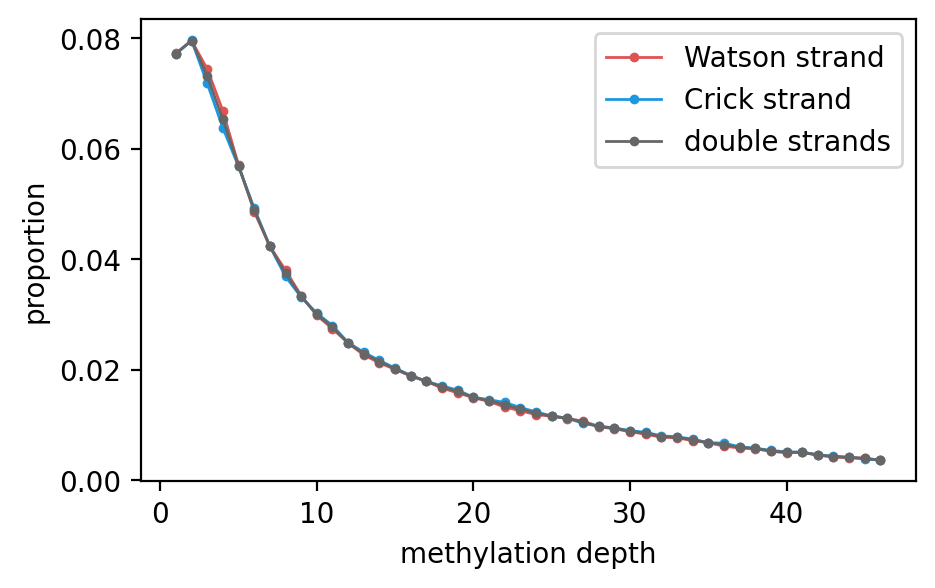

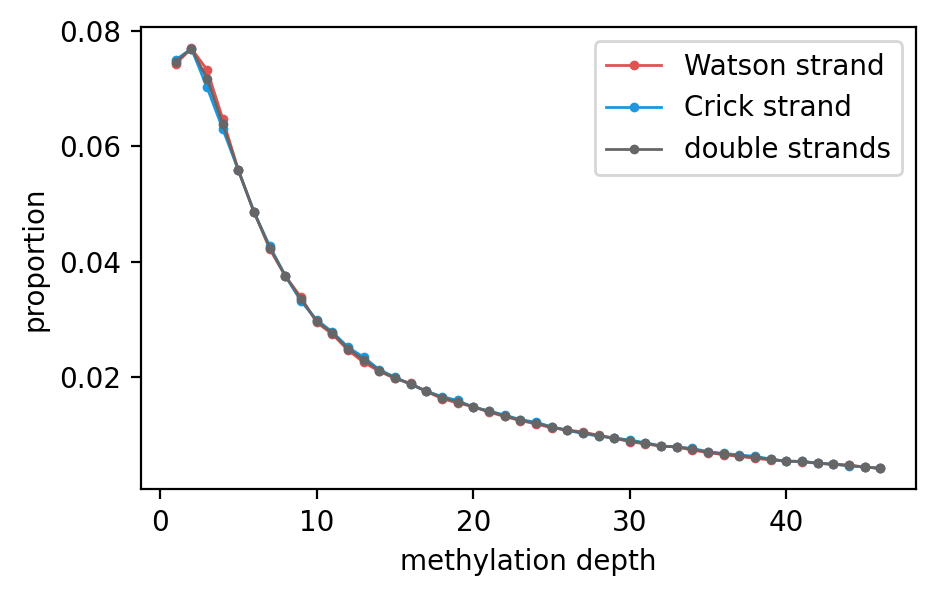

In [95]:
for cg in CONTEXTS:

    x = np.arange(DP_xdepth) + 1
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, depthDiff(dict_genome_covnC[cg]['W'])[:DP_xdepth] / dict_genome_covnC[cg]['W'][0], '.-', c=COLS[1], alpha=1, linewidth=1, markersize=5, label='Watson strand')
    ax.plot(x, depthDiff(dict_genome_covnC[cg]['C'])[:DP_xdepth] / dict_genome_covnC[cg]['C'][0], '.-', c=COLS[0], alpha=1, linewidth=1, markersize=5, label='Crick strand')
    ax.plot(x, depthDiff(dict_genome_covnC[cg]['double'])[:DP_xdepth] / dict_genome_covnC[cg]['double'][0], '.-', c=COL_gray, linewidth=1, markersize=5, label='double strands')
    ax.legend()
    plt.xlabel('methylation depth')
    plt.ylabel('proportion')

    filename = f'img/genome-{cg}-depth-distribution'

    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### whole-genome coverage vs depth

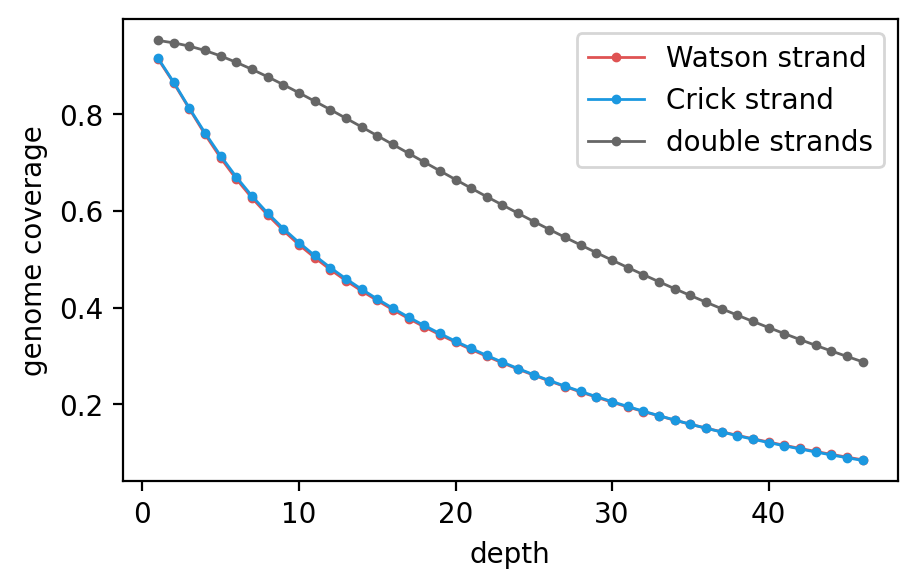

In [81]:
x = np.arange(DP_xdepth) + 1
L = np.sum(length)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, genome_covW[:DP_xdepth]/L, '.-', c=COLS[1], alpha=1, linewidth=1, markersize=5, label='Watson strand')
ax.plot(x, genome_covC[:DP_xdepth]/L, '.-', c=COLS[0], alpha=1, linewidth=1, markersize=5, label='Crick strand')
ax.plot(x, genome_cov[:DP_xdepth]/L, '.-', c=COL_gray, linewidth=1, markersize=5, label='double strands')
ax.legend()
plt.xlabel('depth')
plt.ylabel('genome coverage')

filename = f'img/whole-genome-coverage-vs-depth'

plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### depth distribution of whole genome

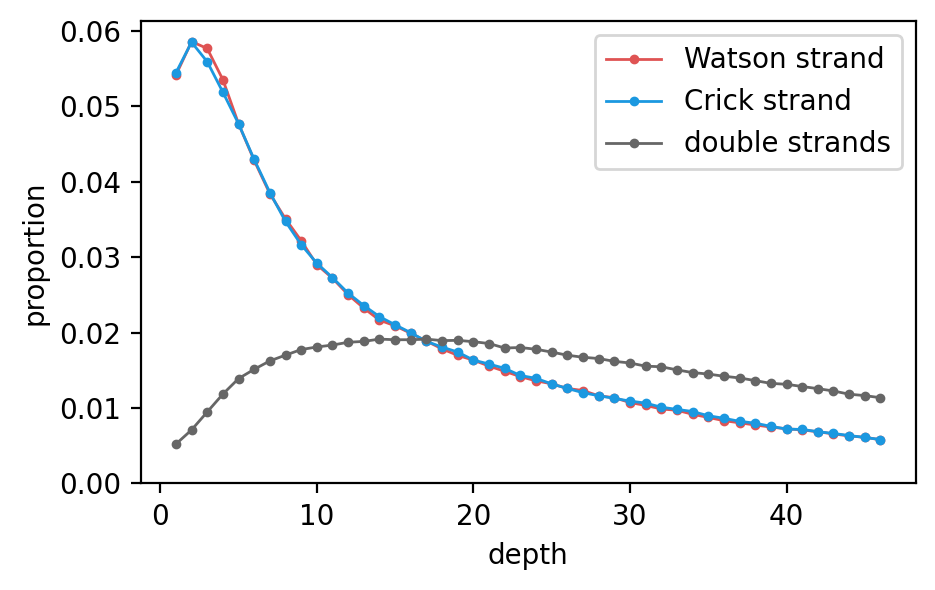

In [82]:
x = np.arange(DP_xdepth) + 1
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, depthDiff(genome_covW)[:DP_xdepth]/genome_covW[0], '.-', c=COLS[1], alpha=1, linewidth=1, markersize=5, label='Watson strand')
ax.plot(x, depthDiff(genome_covC)[:DP_xdepth]/genome_covC[0], '.-', c=COLS[0], alpha=1, linewidth=1, markersize=5, label='Crick strand')
ax.plot(x, depthDiff(genome_cov)[:DP_xdepth]/genome_cov[0], '.-', c=COL_gray, linewidth=1, markersize=5, label='double strands')
ax.legend()
plt.ylim(bottom=0)
plt.xlabel('depth')
plt.ylabel('proportion')

filename = f'img/whole-genome-depth-distribution'

plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## CG kmer

### whole-genome cgkmer summary

In [44]:
kmer = list()
kmer_n = list()
kmer_nW = list()
kmer_nC = list()
kmer_dp = list()
kmer_dpW = list()
kmer_dpC = list()
kmer_meth = list()
kmer_methW = list()
kmer_methC = list()
kmer_cov = list()

for key, value in dict_cgkmer.items():
    kmer.append(key)
    kmer_n.append(value.n)
    kmer_nW.append(value.nW)
    kmer_nC.append(value.nC)
    kmer_dp.append(value.dp / value.n)
    kmer_dpW.append(value.dpW / value.nW)
    kmer_dpC.append(value.dpC / value.nC)
    kmer_meth.append(nandivide( value.me, value.cov))
    kmer_methW.append(nandivide(value.meW, value.covW))
    kmer_methC.append(nandivide(value.meC, value.covC))
    kmer_cov.append(value.cov / value.n)

# df = pd.DataFrame({'kmer':kmer, 'n':n, 'nW':nW, 'nC':nC, 'dp':dp, 'dpW':dpW, 'dpC':dpC})
dict_kmer = {
    'kmer':kmer, 
    'n': np.asarray(kmer_n), 
    'nW': np.asarray(kmer_nW), 
    'nC': np.asarray(kmer_nC), 
    'dp': np.asarray(kmer_dp), 
    'dpW': np.asarray(kmer_dpW), 
    'dpC': np.asarray(kmer_dpC),
    'me': np.asarray(kmer_meth),
    'meW': np.asarray(kmer_methW),
    'meC': np.asarray(kmer_methC),
    'cov': np.asarray(kmer_cov)
    }

def relativeFreq (x, mean=1/256):
    return x/np.sum(x)/mean

def abline(intercept, slope, **kw):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', **kw)

maxdp = 50

### frequency

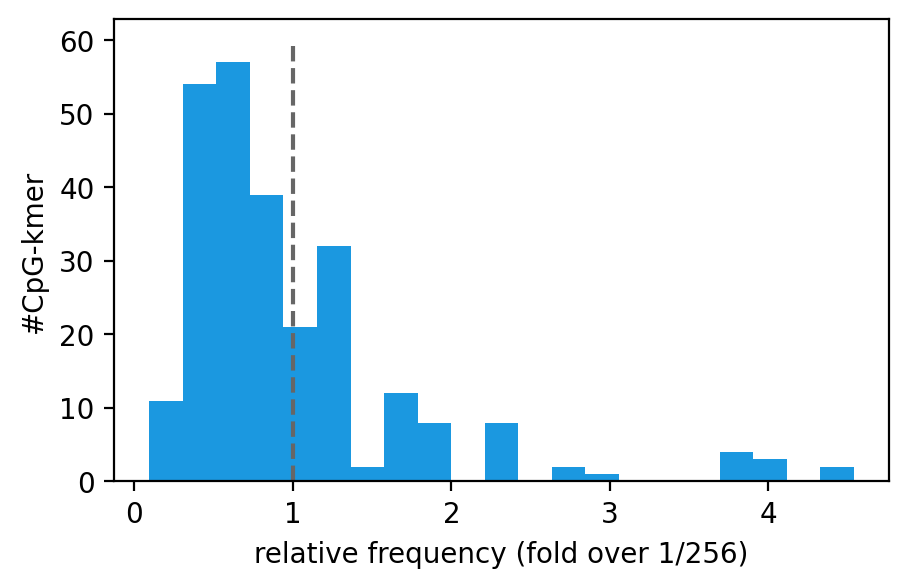

In [24]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(relativeFreq(dict_kmer['n']), bins=21, color=COLS[0])
ax.vlines(1, *ax.get_ylim(), linestyles='dashed', color=COL_gray)
plt.xlabel('relative frequency (fold over 1/256)')
plt.ylabel('#CpG-kmer')

filename = f'img/kmer-frequency-dist'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### CG kmer freq on two strands

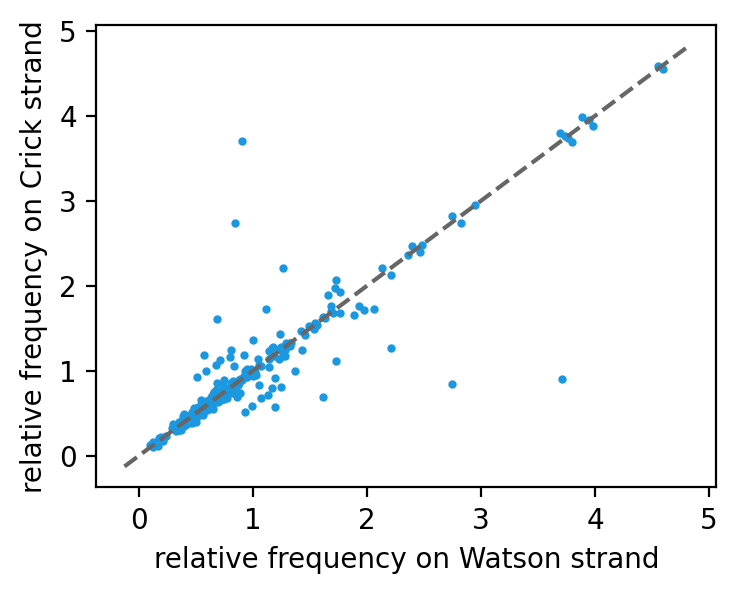

In [51]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(relativeFreq(dict_kmer['nW']), relativeFreq(dict_kmer['nC']), 'o', c=COLS[0], markersize=2)
abline(0, 1, color=COL_gray)
plt.xlabel('relative frequency on Watson strand')
plt.ylabel('relative frequency on Crick strand')

filename = f'img/kmer-stranded-frequency'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### cgkmer meth on two strands

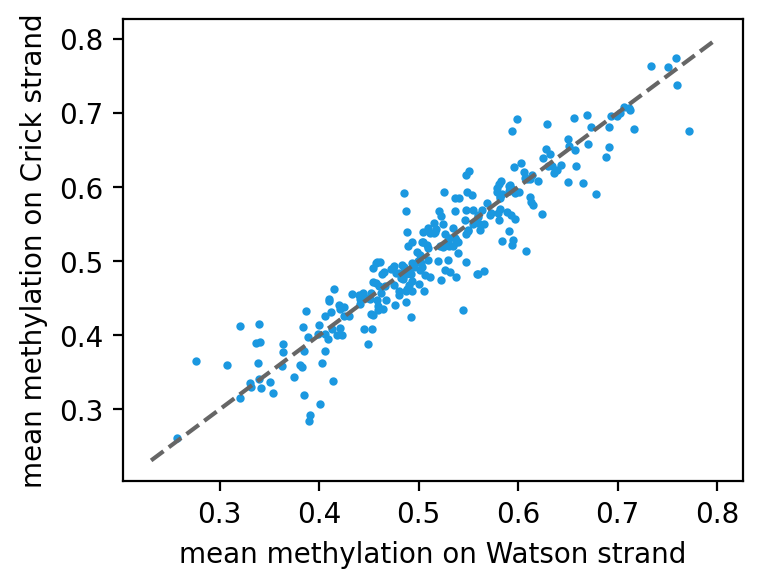

In [50]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(dict_kmer['meW'][:,0], dict_kmer['meC'][:,0], 'o', c=COLS[0], markersize=2)
abline(0, 1, color=COL_gray)
plt.xlabel('mean methylation on Watson strand')
plt.ylabel('mean methylation on Crick strand')

filename = f'img/kmer-stranded-me-dp1'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [54]:
# interactive plot
json.dumps({'nW': list(signif(relativeFreq(dict_kmer['nW']))),
            'nC': list(signif(relativeFreq(dict_kmer['nC']))),
            'n': list(signif(relativeFreq(dict_kmer['n']))),
            'cgkmer': dict_kmer['kmer'],
            'mean_dp': list(signif(dict_kmer['dp'], 2)),
            'meWdp1': list(signif(dict_kmer['meW'][:,0])),
            'meCdp1': list(signif(dict_kmer['meC'][:,0])),
            'medp1': list(signif(dict_kmer['me'][:,0])),
            'meW': list(signif(dict_kmer['meW'][:,0])),
            'meC': list(signif(dict_kmer['meC'][:,0])),

            'dp': list(range(1, maxdp + 1)),
            'cov': [list(signif(x)) for x in dict_kmer['cov'][:,:maxdp]],
            'me': [list(signif(x)) for x in dict_kmer['me'][:,:maxdp]],
            # 'cgkmer': dict_kmer['kmer']
            }
            )

'{"nW": [0.711, 1.131, 0.801, 1.165, 0.496, 0.51, 0.667, 1.118, 1.728, 0.411, 0.431, 1.044, 1.142, 0.405, 0.438, 1.705, 1.687, 0.571, 3.985, 3.886, 4.551, 4.592, 0.603, 0.639, 1.324, 1.338, 0.51, 0.537, 1.727, 2.064, 0.314, 0.321, 0.461, 0.416, 0.865, 0.858, 2.48, 0.905, 0.889, 0.865, 0.88, 0.431, 0.467, 1.179, 1.283, 1.053, 1.071, 1.23, 1.143, 1.889, 1.656, 1.292, 1.323, 3.948, 0.66, 0.749, 0.643, 0.592, 1.245, 1.286, 1.191, 0.922, 0.566, 0.563, 1.323, 1.326, 0.903, 3.708, 2.394, 2.468, 0.399, 0.417, 0.659, 0.628, 0.772, 0.682, 1.42, 1.461, 1.563, 1.544, 0.756, 0.798, 0.68, 0.699, 0.928, 0.931, 0.84, 2.747, 1.239, 1.259, 1.973, 1.719, 0.934, 1.001, 0.923, 0.945, 0.533, 0.572, 0.419, 0.403, 1.368, 1.006, 3.689, 3.801, 2.824, 2.744, 1.242, 1.617, 1.634, 0.518, 0.468, 0.722, 0.68, 2.36, 3.739, 3.765, 2.214, 2.132, 1.002, 0.998, 0.716, 0.679, 0.499, 0.399, 0.798, 0.79, 0.355, 0.306, 1.764, 1.934, 0.841, 0.841, 1.019, 0.988, 1.687, 1.761, 0.546, 0.569, 0.47, 0.385, 0.688, 0.862, 0.564, 0.5

### kmer meth vs frequency

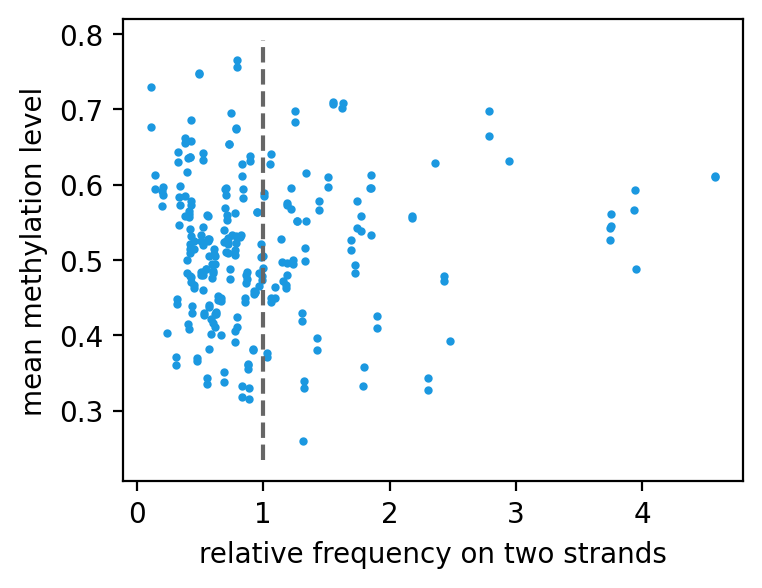

In [49]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(relativeFreq(dict_kmer['n']), dict_kmer['me'][:,0], 'o', c=COLS[0], markersize=2)

plt.xlabel("relative frequency on two strands")
plt.ylabel("mean methylation level")
plt.vlines(1, ax.get_ylim()[0], ax.get_ylim()[1], colors=COL_gray, linestyles='dashed')

filename = f'img/kmer-meth-vs-frequency'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### kmer coverage vs DP

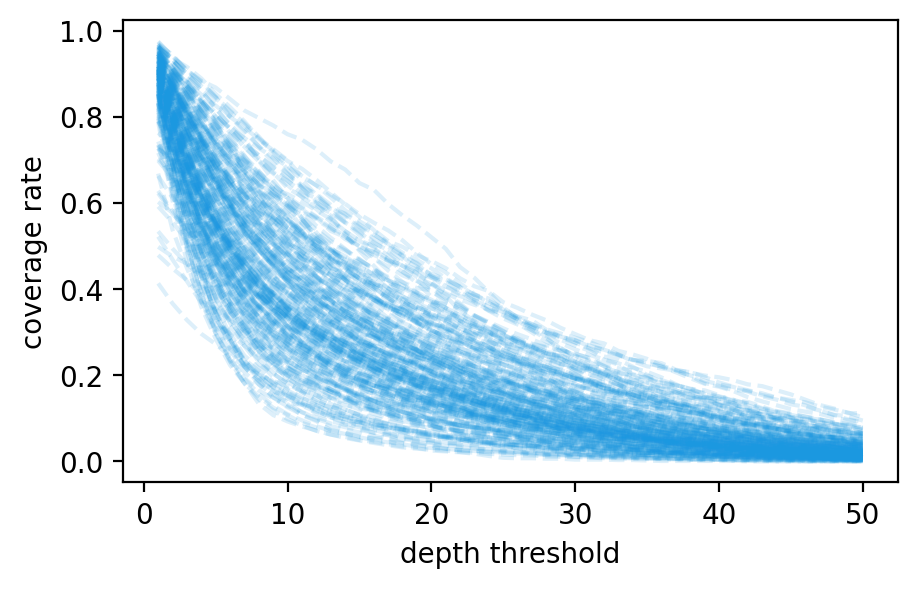

In [24]:
maxdp = 50
fig, ax = plt.subplots(figsize=(5, 3))
dp = np.arange(start=1, stop=maxdp+1)
for i in range(np.shape(dict_kmer["cov"])[0]):
    ax.plot(dp, dict_kmer['cov'][i,:maxdp], '--', c=COLS[0], alpha=0.15)
plt.xlabel("depth threshold")
plt.ylabel("coverage rate")

filename = f'img/kmer-coverage-vs-depth'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [25]:
# interactive plot
json.dumps(
    {
        'dp': list(range(1, maxdp+1)),
        'cov': [list(signif(x)) for x in dict_kmer['cov'][:,:maxdp]],
        'me': [list(signif(x)) for x in dict_kmer['me'][:,:maxdp]],
        'cgkmer': dict_kmer['kmer']
    }
    )

'{"dp": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], "cov": [[0.842, 0.823, 0.794, 0.772, 0.746, 0.719, 0.685, 0.664, 0.633, 0.62, 0.602, 0.582, 0.562, 0.534, 0.512, 0.492, 0.469, 0.454, 0.436, 0.412, 0.397, 0.383, 0.373, 0.358, 0.346, 0.336, 0.327, 0.305, 0.289, 0.281, 0.267, 0.259, 0.248, 0.232, 0.22, 0.215, 0.21, 0.199, 0.187, 0.178, 0.172, 0.162, 0.151, 0.143, 0.132, 0.126, 0.118, 0.108, 0.104, 0.094], [0.838, 0.806, 0.763, 0.725, 0.688, 0.651, 0.603, 0.571, 0.546, 0.508, 0.486, 0.459, 0.432, 0.412, 0.395, 0.375, 0.359, 0.343, 0.329, 0.316, 0.303, 0.287, 0.275, 0.263, 0.25, 0.24, 0.227, 0.219, 0.213, 0.195, 0.185, 0.178, 0.164, 0.154, 0.145, 0.139, 0.132, 0.125, 0.115, 0.109, 0.107, 0.099, 0.091, 0.088, 0.081, 0.078, 0.073, 0.069, 0.067, 0.062], [0.826, 0.79, 0.756, 0.722, 0.69, 0.661, 0.634, 0.605, 0.575, 0.555, 0.533, 0.515, 0.493, 0.

### kmer meth vs DP >= k

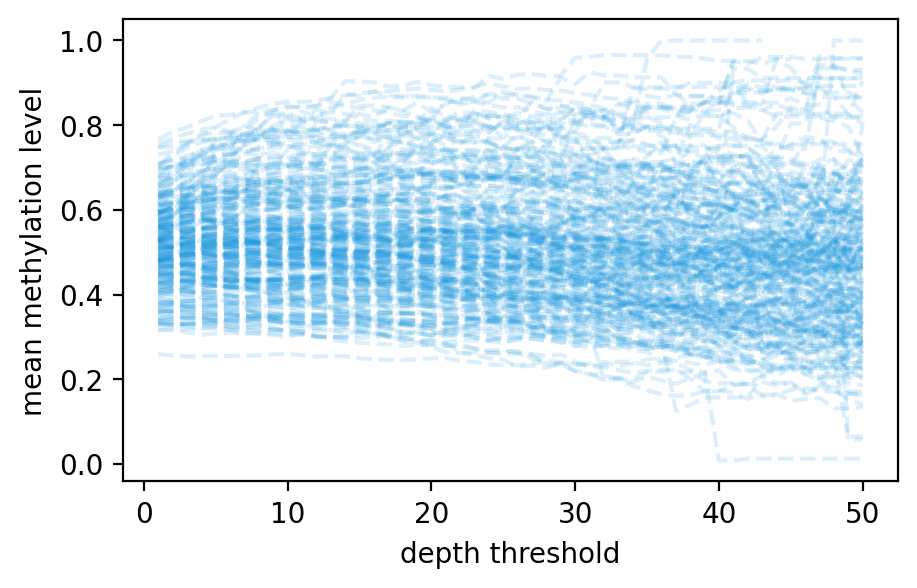

In [56]:
fig, ax = plt.subplots(figsize=(5, 3))
dp = np.arange(start=1, stop=maxdp+1)
for i in range(np.shape(dict_kmer['cov'])[0]):
    ax.plot(dp, dict_kmer['me'][i,:maxdp], '--', c=COLS[0], alpha=0.15)
plt.xlabel("depth threshold")
plt.ylabel("mean methylation level")

filename = f'img/kmer-meth-vs-depth'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### kmer dp vs frequency

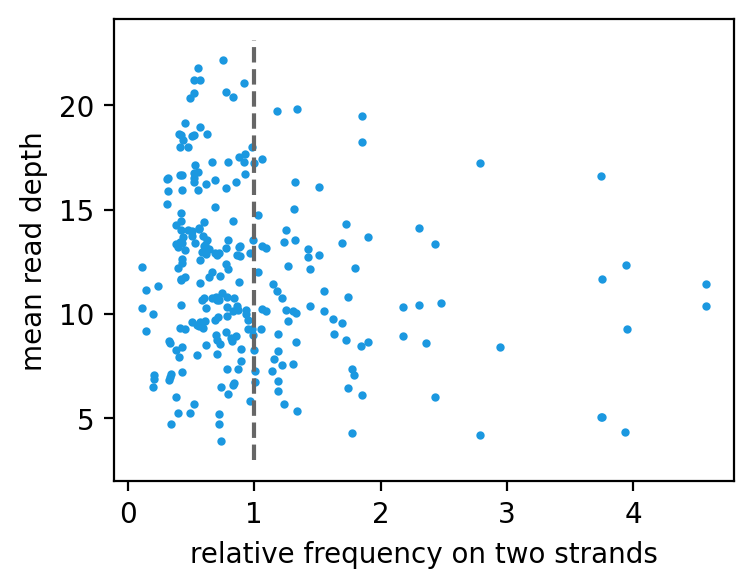

In [55]:
fig, ax = plt.subplots(figsize=(4, 3))

# ax.plot(relativeFreq(dict_kmer['n']), dict_kmer['cov'][:,0], 'o', c=COLS[0], markersize=3)
ax.plot(relativeFreq(dict_kmer['n']), dict_kmer['dp'], 'o', c=COLS[0], markersize=2)
plt.xlabel("relative frequency on two strands")
plt.ylabel("mean read depth")
plt.vlines(1, ax.get_ylim()[0], ax.get_ylim()[1], colors=COL_gray, linestyles='dashed')

filename = f'img/kmer-mean-depth-vs-freq'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## interactive plot

## Saturation curve

In [ ]:
def saturation_curve_binning(sampled_bases: int, cov: NDArray):

    maxdp = len(cov) - np.argmax(cov[::-1] > 0)
    depths = np.repeat(np.arange(1, maxdp+1), cov[:maxdp])

    if sampled_bases >= np.sum(depths):
        return np.array(cov[ [0,2,4,9] ])
    # sampled_bases = min(sampled_bases, np.sum(cov[:maxdp]*np.arange(1, maxdp+1)))

    # gen = np.random.Generator(np.random.PCG64())
    sampling = gen.multivariate_hypergeometric(depths, sampled_bases)

    return np.array([np.sum(sampling>=1), np.sum(sampling>=3), np.sum(sampling>=5), np.sum(sampling>=10)])

In [ ]:
# class Saturation_curve(NamedTuple):
#     curve: NDArray
#     cov_rate: float # whole-genome coverage rate, DP>=1
#     unseq_rate: float # unsequenced prop of bases
#     DNAlost_rate: float # DNA template lost


### DNA template lose

In [ ]:
## coverage rate single-strand DP>=1
single_DP1_coverage = (binning_covW[:,0].sum() + binning_covC[:,0].sum()) / length.sum() / 2

# unsequenced base prop by Emperical Bayes
prop_unsequenced =  (binning_covW[:,0].sum() - binning_covW[:,1].sum() + binning_covC[:,0].sum() - binning_covC[:,1].sum()) / totalBases
# prop of whole genome
prop_unsequenced = single_DP1_coverage * prop_unsequenced/(1-prop_unsequenced)
DNA_lost = max(0, 1 -prop_unsequenced - single_DP1_coverage)

single_DP1_coverage, prop_unsequenced, DNA_lost

(0.8975809177360072, 0.004799693223465885, 0.09761938904052692)

In [ ]:
def saturation_curve(breaks=30):
    """
    single-stranded saturation curve
    """

    # gen = np.random.Generator(np.random.PCG64())
    
    genome_coverages = np.zeros(shape=(breaks+1, 4))
    # covsum = binning_depth.sum(axis=0)
    # coverage rate for all reads
    genome_coverages[breaks,:] = np.array([
        binning_covW[:,0].sum() + binning_covC[:,0].sum(),
        binning_covW[:,2].sum() + binning_covC[:,2].sum(),
        binning_covW[:,4].sum() + binning_covC[:,4].sum(),
        binning_covW[:,9].sum() + binning_covC[:,9].sum()]
        )/length.sum()/2
    

    # sampled_bases = np.logspace(0, np.log10(totalDepth.sum()), breaks+1, dtype=np.int64) -1
    sampled_basesW = np.linspace(0, totalBasesW, breaks+1, dtype=np.int64)
    sampled_basesC = np.linspace(0, totalBasesC, breaks+1, dtype=np.int64)
    for i in np.arange(1, breaks):

        # Watson strand
        bin_basesW = gen.multinomial(sampled_basesW[i], totalDepthW/totalBasesW, size=1)[0,:]
        # DP >= 1,3,5,10
        coveraged_basesW = [
            saturation_curve_binning(bin_basesW[j], binning_depthW[j,:])
            for j in range(len(length))
            ]

        # Crick strand
        bin_basesC = gen.multinomial(sampled_basesC[i], totalDepthC/totalBasesC, size=1)[0,:]
        # bin_bases = np.fmin(bin_bases, totalDepth)

        # DP >= 1,3,5,10
        coveraged_basesC = [
            saturation_curve_binning(bin_basesC[j], binning_depthC[j,:])
            for j in range(len(length))
            ]
        
        genome_coverages[i,:] = (np.asarray(coveraged_basesW).sum(axis=0) + np.asarray(coveraged_basesC).sum(axis=0))/length.sum()/2

    # add mean sequencing depth
    return np.hstack([
        genome_coverages, 
        (sampled_basesW+sampled_basesC).reshape((-1,1))/length.sum()/2
        ])


In [ ]:
sc = saturation_curve(breaks=30)

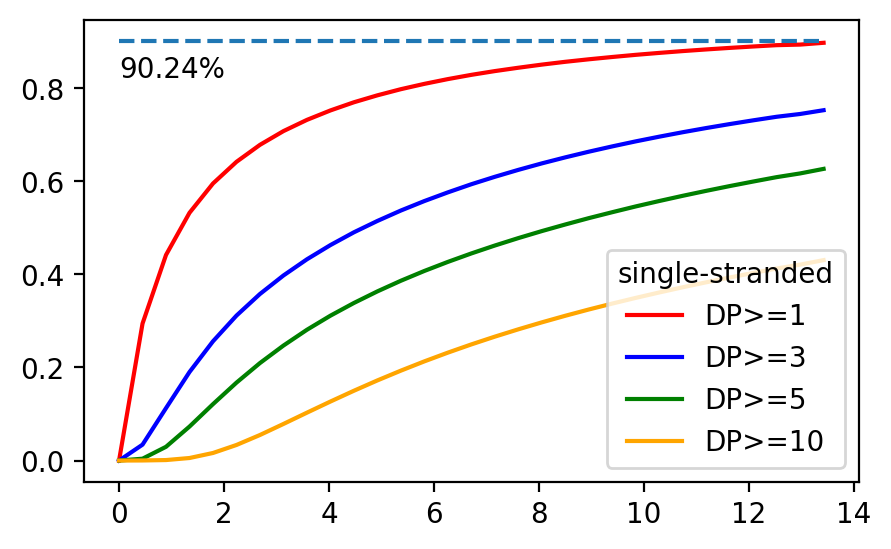

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

dp = [1,3,5,10]
cols = ['red', 'blue', 'green', 'orange']
size = np.shape(sc)
x = sc[:,-1]
for i in range(size[1]-1):
    ax.plot(x, sc[:,i], '-', c=cols[i], alpha=1, label='DP>='+str(dp[i]))
ax.plot(np.linspace(0, sc[-1, -1], 10), np.repeat(1-DNA_lost, 10), '--')
ax.text(0, 1-DNA_lost-0.08, f'{100-DNA_lost*100:.2f}%')

ax.legend(title='single-stranded')
plt.show()

### fit the culmualtive coverage curve

In [ ]:
from scipy.optimize import curve_fit

def logodds(x):
    return np.log(x/(1-x))

def logistic(x):
    return np.exp(x)/(1 + np.exp(x))

def f(x, a, b, c, d, e):
    return e - np.exp(a*x+b)/(1+np.exp(c*x+d))

def f2(x, a, b, c,d):
    return a - np.exp(b*x*+c)


x = sc.curve[:,-1]
popt, pcov = curve_fit(f, x[2:], sc.curve[2:,1], method='trf')

In [ ]:
f(0, *popt), f(50, *popt)

(0.9565358824917383, 0.9561825208260494)

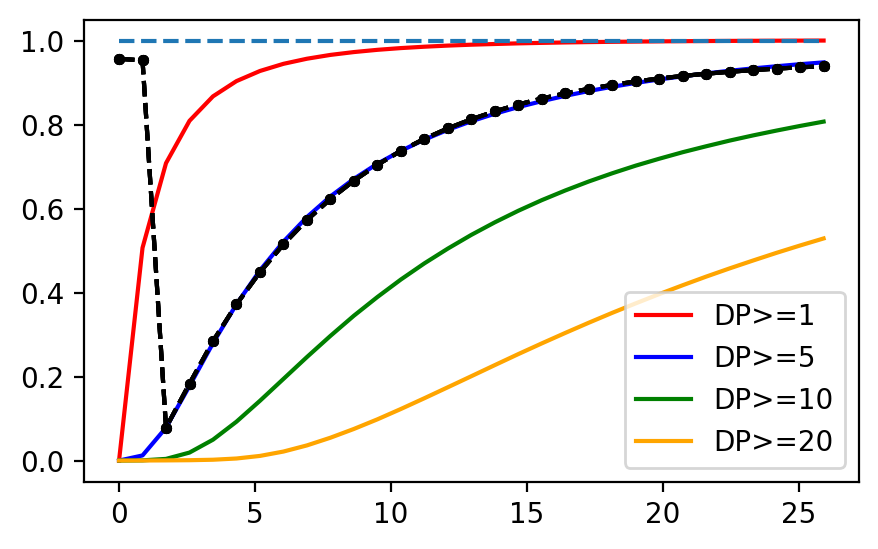

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

dp = [1,5,10,20]
cols = ['red', 'blue', 'green', 'orange']
size = np.shape(sc.curve)
for i in range(size[1]-1):
    ax.plot(x, sc.curve[:,i], '-', c=cols[i], alpha=1, label='DP>='+str(dp[i]))
    ax.plot(x, f(x, *popt), '.--', c='black')
ax.plot(np.linspace(0, sc.curve[-1, -1], 10), np.repeat(1., 10), '--')
ax.legend()
plt.show()